In [1]:
import warnings
from glob import glob
from itertools import product
from typing import Callable

import hvplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import seaborn_polars as snl
from catboost import CatBoostClassifier
from dataset import Dataset
from eda import (
    build_barplot_by_column,
    check_distributions_for_similarity,
    draw_overlapping_densities,
)
from lf_processing import handle_dates, scan_file, scan_files
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (
    StratifiedGroupKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm.notebook import tqdm

RAND = 0
N_FOLDS = 5
TRAIN_PREFIX = "parquet_files/train/train_"
TEST_PREFIX = "parquet_files/test/test_"
sns.set_theme(style="ticks", font_scale=1.7)
warnings.filterwarnings("ignore")

# Feature engineering

## Анализ корреляции признаков

In [8]:
def plot_corr_heatmap(df: pd.DataFrame) -> None:
    """
    Plot correlation heatmap of dataframe df

    Parameters
    ----------
    df: pd.DataFrame
        columns

    Returns
    -------
    None
    """
    plt.figure(figsize=(12, 7))
    cor = df.corr(method="spearman")
    matrix = np.triu(cor)
    sns.heatmap(cor, annot=True, mask=matrix)
    plt.show()

In [6]:
ds = Dataset()
lf = ds.generate_data()
lf.width

290

Далее будем объединять схожие по смыслу колонки в объединенной таблице. Значения в колонках с датой вычитаем из значений в колонке decision_date и переводим в дни.

- actualdpd_943P и actualdpdtolerance_344P **(Days Past Due (DPD) of previous contract (actual))** объединим
- totaloutstanddebtvalue_668A (Total outstanding debt for the closed contracts in the credit bureau.) и outstandingamount_354A (Outstanding amount for closed credit contract in credit bureau) объединим, т.к. коэффициент корреляции у них 97 %
- Колонки с birthdate преобразуем в возраст в годах с помощью вычитания из даты decision_date

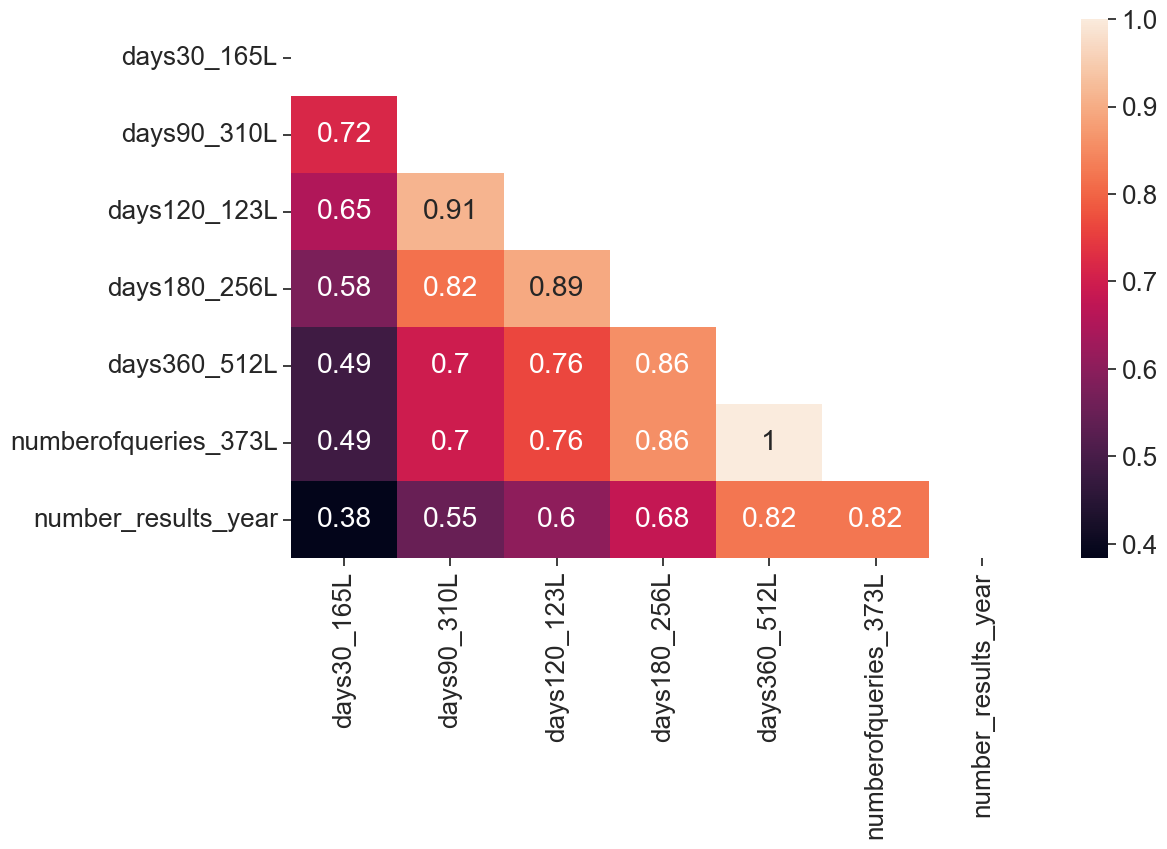

In [20]:
df = (
    lf.select(
        "days30_165L",
        "days90_310L",
        "days120_123L",
        "days180_256L",
        "days360_512L",
        "numberofqueries_373L",
        "number_results_year",
    )
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

- Колонку 'number_results_year' мы получили из 4 колонок'firstquarter_103L', 'secondquarter_766L', 'thirdquarter_1082L', 'fourthquarter_440L'.
- Видим что по коэффициентам корреляции и по смыслу можно объединить  'number_results_year' 'numberofqueries_373L' 'days360_512L' в новый признак numberofqueries_year
- 'days90_310L', 'days120_123L', 'days180_256L' соединим в признак 'days_90_120_180'

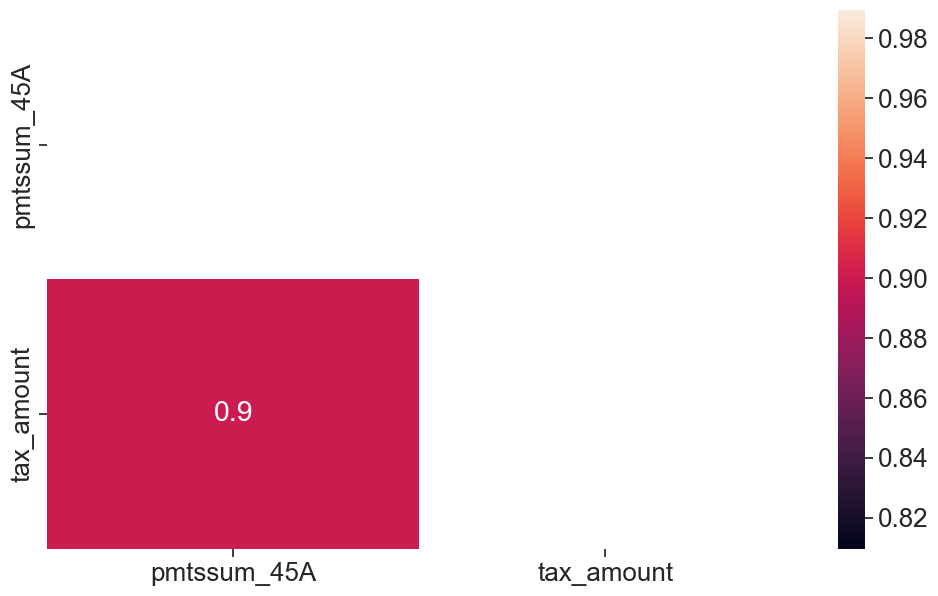

In [69]:
df = lf.select("pmtssum_45A", "tax_amount").collect().to_pandas()
plot_corr_heatmap(df)

Колонки 'pmtssum_45A' (Sum of tax deductions for the client) и 'tax_amount' (Tax deductions amount tracked by the government registry, объединенная сумма из таблиц tax_registry) сильно скоррелированы, их можно объединить.

In [71]:
lf.select("pmtssum_45A", "tax_amount").describe()

shape: (9, 3)
┌────────────┬──────────────┬─────────────┐
│ statistic  ┆ pmtssum_45A  ┆ tax_amount  │
│ ---        ┆ ---          ┆ ---         │
│ str        ┆ f64          ┆ f64         │
╞════════════╪══════════════╪═════════════╡
│ count      ┆ 572638.0     ┆ 457934.0    │
│ null_count ┆ 954021.0     ┆ 1.068725e6  │
│ mean       ┆ 13199.93597  ┆ 4433.241401 │
│ std        ┆ 18117.218312 ┆ 7086.987408 │
│ min        ┆ 0.0          ┆ 0.0         │
│ 25%        ┆ 3156.4001    ┆ 1266.6      │
│ 50%        ┆ 8392.0       ┆ 2664.2      │
│ 75%        ┆ 16992.0      ┆ 5030.8003   │
│ max        ┆ 476843.4     ┆ 344250.0    │
└────────────┴──────────────┴─────────────┘

In [73]:
lf.filter(
    pl.col("pmtssum_45A").is_not_null() & pl.col("tax_amount").is_not_null()
).select("pmtssum_45A", "tax_amount").slice(0, 9).collect()

shape: (9, 2)
┌─────────────┬────────────┐
│ pmtssum_45A ┆ tax_amount │
│ ---         ┆ ---        │
│ f64         ┆ f64        │
╞═════════════╪════════════╡
│ 8873.4      ┆ 3616.4001  │
│ 14051.736   ┆ 2564.0     │
│ 151.5       ┆ 151.6      │
│ 11099.561   ┆ 5637.8003  │
│ 12417.468   ┆ 2628.6     │
│ 7218.008    ┆ 1364.8     │
│ 1700.0      ┆ 425.0      │
│ 3749.4001   ┆ 1200.2001  │
│ 5195.0      ┆ 945.0      │
└─────────────┴────────────┘

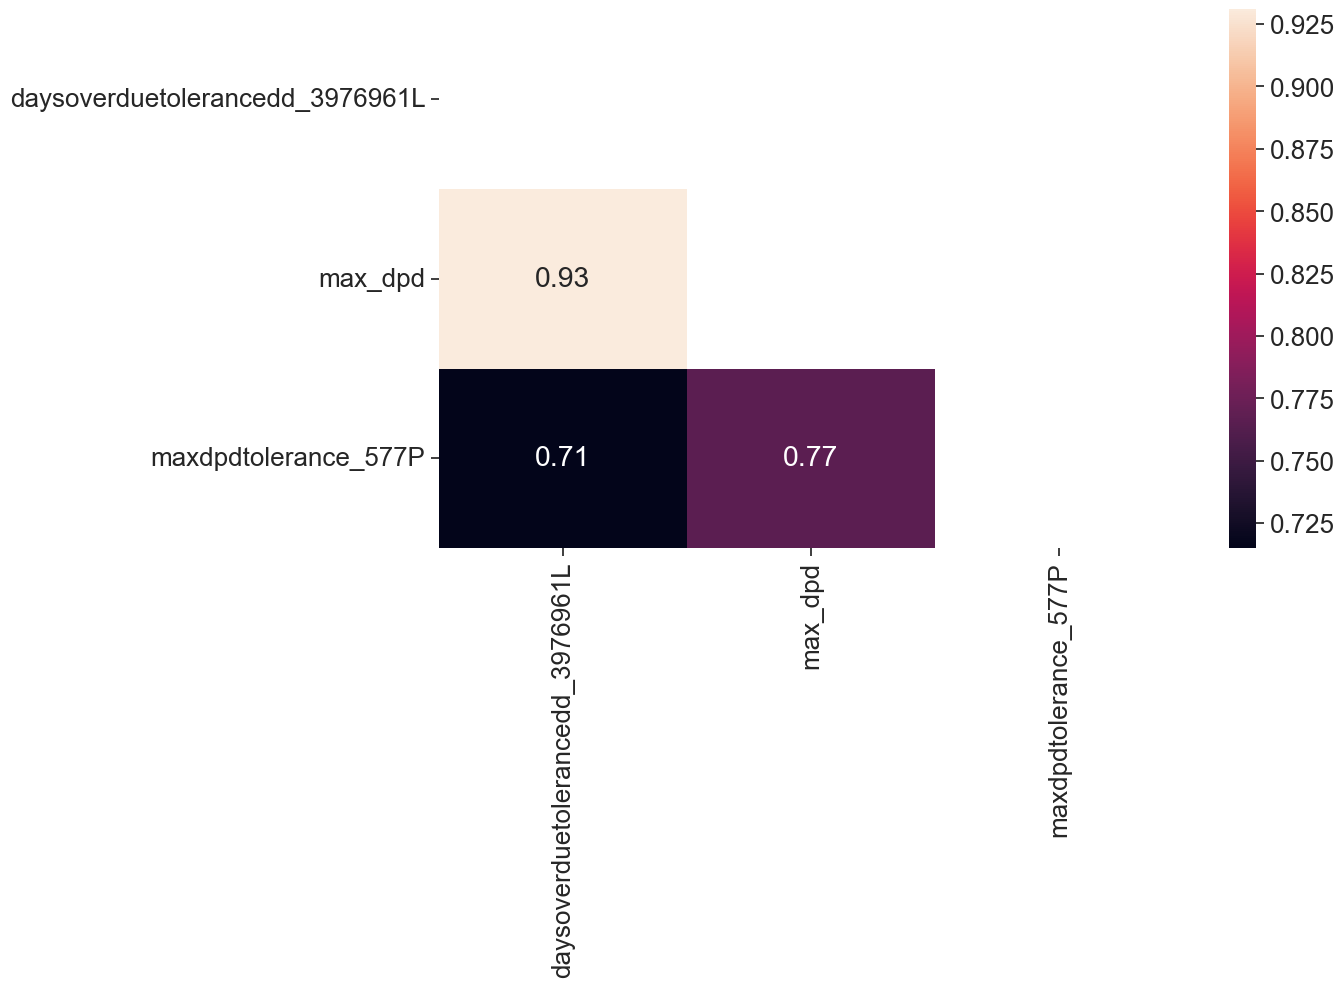

In [103]:
df = (
    lf.select("daysoverduetolerancedd_3976961L", "max_dpd", "maxdpdtolerance_577P")
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

In [104]:
lf.select(
    "daysoverduetolerancedd_3976961L", "max_dpd", "maxdpdtolerance_577P"
).describe()

shape: (9, 4)
┌────────────┬─────────────────────────────────┬────────────┬──────────────────────┐
│ statistic  ┆ daysoverduetolerancedd_3976961L ┆ max_dpd    ┆ maxdpdtolerance_577P │
│ ---        ┆ ---                             ┆ ---        ┆ ---                  │
│ str        ┆ f64                             ┆ f64        ┆ f64                  │
╞════════════╪═════════════════════════════════╪════════════╪══════════════════════╡
│ count      ┆ 1.526659e6                      ┆ 1.526659e6 ┆ 1.07569e6            │
│ null_count ┆ 0.0                             ┆ 0.0        ┆ 450969.0             │
│ mean       ┆ 67.79134                        ┆ 42.724671  ┆ 42.158345            │
│ std        ┆ 406.09151                       ┆ 255.522555 ┆ 251.051895           │
│ min        ┆ 0.0                             ┆ 0.0        ┆ 0.0                  │
│ 25%        ┆ 0.0                             ┆ 0.0        ┆ 0.0                  │
│ 50%        ┆ 0.0                             ┆ 0.0        ┆ 0.0                  │
│ 75%        ┆ 6.0                             ┆ 5.0        ┆ 5.0                  │
│ max        ┆ 5337.0                          ┆ 4629.0     ┆ 4362.0               │
└────────────┴─────────────────────────────────┴────────────┴──────────────────────┘

- 'daysoverduetolerancedd_3976961L' Number of days that past after the due date (with tolerance).
- 'maxdpdtolerance_577P' - Maximum DPD with tolerance (on previous application/s).
- 'max_dpd' includes (maxdpdlast12m_727P,Maximum days past due in the past 12 months.), (maxdpdlast24m_143P,Maximal days past due in the last 24 months.), (maxdpdlast3m_392P,Maximum number of days past due in last 3 months), (maxdpdlast6m_474P,Maximum days past due in the last 6 months), (maxdpdlast9m_1059P,Maximum days past due in last 9 months), (maxdpdtolerance_374P,Maximum number of days past due (with tolerance)), (maxdpdfrom6mto36m_3546853P,Maximum Days Past Due (DPD) in the period ranging from 6 to 36 months)

- Эти 3 колонки объединим в одну 'max_dpd_overdue'

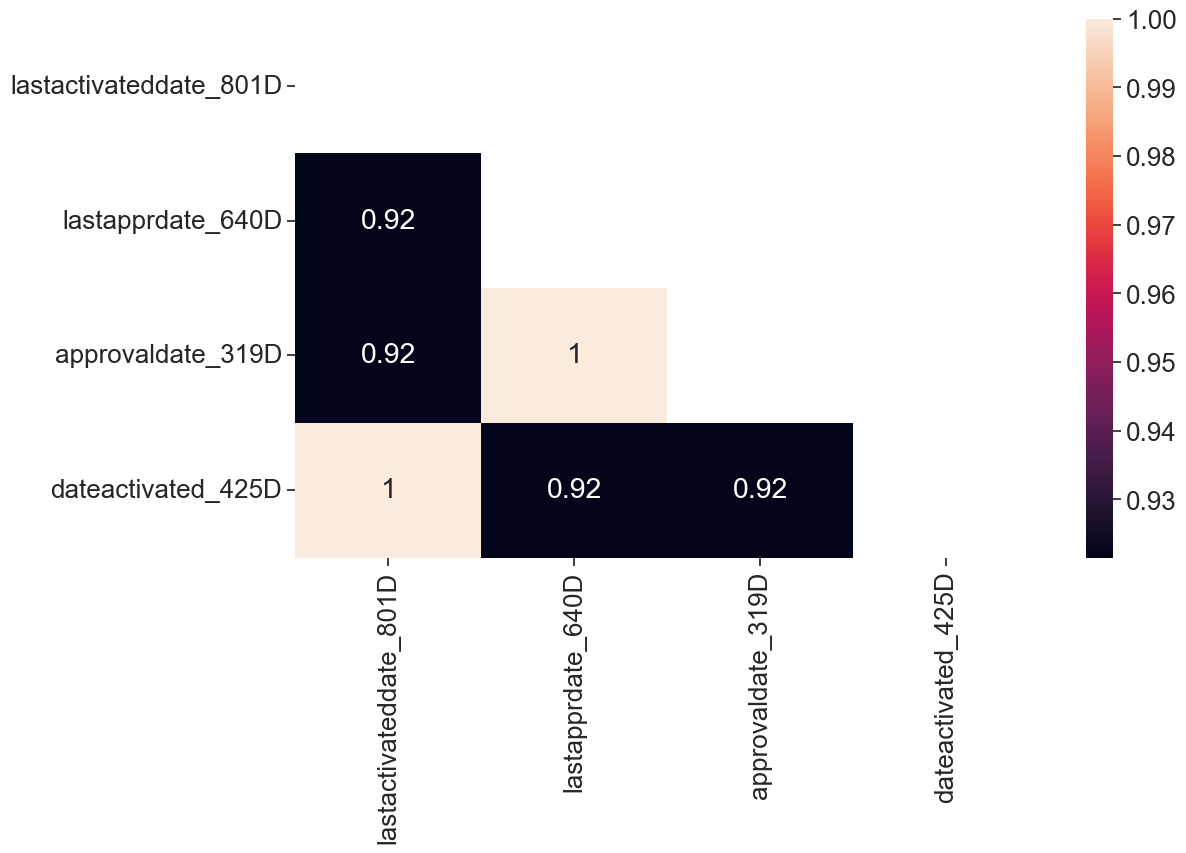

In [115]:
df = (
    lf.select(
        "lastactivateddate_801D",
        "lastapprdate_640D",
        "approvaldate_319D",
        "dateactivated_425D",
    )
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

In [116]:
lf.select(
    "lastactivateddate_801D",
    "lastapprdate_640D",
    "approvaldate_319D",
    "dateactivated_425D",
).describe()

shape: (9, 5)
┌────────────┬────────────────────────┬───────────────────┬───────────────────┬────────────────────┐
│ statistic  ┆ lastactivateddate_801D ┆ lastapprdate_640D ┆ approvaldate_319D ┆ dateactivated_425D │
│ ---        ┆ ---                    ┆ ---               ┆ ---               ┆ ---                │
│ str        ┆ f64                    ┆ f64               ┆ f64               ┆ f64                │
╞════════════╪════════════════════════╪═══════════════════╪═══════════════════╪════════════════════╡
│ count      ┆ 1.073072e6             ┆ 1.084618e6        ┆ 1.08366e6         ┆ 1.071981e6         │
│ null_count ┆ 453587.0               ┆ 442041.0          ┆ 442999.0          ┆ 454678.0           │
│ mean       ┆ -630.500206            ┆ -609.964219       ┆ -609.460934       ┆ -629.972694        │
│ std        ┆ 907.793826             ┆ 891.218978        ┆ 890.670899        ┆ 907.241935         │
│ min        ┆ -5352.0                ┆ -5354.0           ┆ -5354.0           ┆ -5352.0            │
│ 25%        ┆ -647.0                 ┆ -626.0            ┆ -625.0            ┆ -646.0             │
│ 50%        ┆ -306.0                 ┆ -297.0            ┆ -297.0            ┆ -306.0             │
│ 75%        ┆ -145.0                 ┆ -139.0            ┆ -139.0            ┆ -144.0             │
│ max        ┆ 14.0                   ┆ 14.0              ┆ 14.0              ┆ 14.0               │
└────────────┴────────────────────────┴───────────────────┴───────────────────┴────────────────────┘

- lastactivateddate_801D,Contract activation date for previous applications.
- lastapprdate_640D,Date of approval on client's most recent previous application.
- approvaldate_319D,Approval Date of Previous Application
- dateactivated_425D,Contract activation date of the applicant's previous application.
- Эти 4 колонки объединим

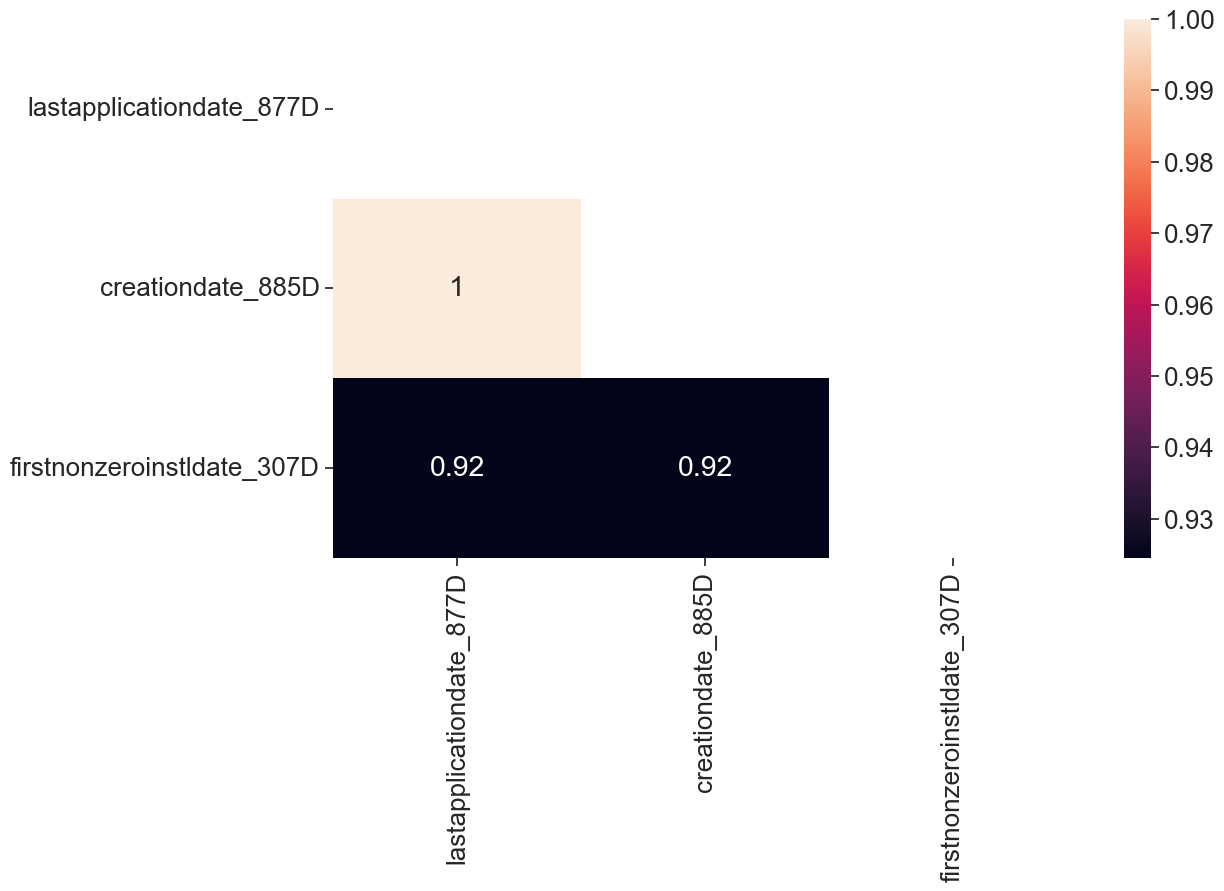

In [121]:
df = (
    lf.select(
        "lastapplicationdate_877D", "creationdate_885D", "firstnonzeroinstldate_307D"
    )
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

In [122]:
lf.select(
    "lastapplicationdate_877D", "creationdate_885D", "firstnonzeroinstldate_307D"
).describe()

shape: (9, 4)
┌────────────┬──────────────────────────┬───────────────────┬────────────────────────────┐
│ statistic  ┆ lastapplicationdate_877D ┆ creationdate_885D ┆ firstnonzeroinstldate_307D │
│ ---        ┆ ---                      ┆ ---               ┆ ---                        │
│ str        ┆ f64                      ┆ f64               ┆ f64                        │
╞════════════╪══════════════════════════╪═══════════════════╪════════════════════════════╡
│ count      ┆ 1.221522e6               ┆ 1.221522e6        ┆ 1.191786e6                 │
│ null_count ┆ 305137.0                 ┆ 305137.0          ┆ 334873.0                   │
│ mean       ┆ -468.985709              ┆ -468.985709       ┆ -496.348726                │
│ std        ┆ 748.096966               ┆ 748.096966        ┆ 801.271864                 │
│ min        ┆ -5354.0                  ┆ -5354.0           ┆ -5323.0                    │
│ 25%        ┆ -495.0                   ┆ -495.0            ┆ -533.0                     │
│ 50%        ┆ -217.0                   ┆ -217.0            ┆ -217.0                     │
│ 75%        ┆ -78.0                    ┆ -78.0             ┆ -62.0                      │
│ max        ┆ 14.0                     ┆ 14.0              ┆ 47.0                       │
└────────────┴──────────────────────────┴───────────────────┴────────────────────────────┘

- lastapplicationdate_877D,Date of previous customer's application.
- creationdate_885D,Date when previous application was created.
- firstnonzeroinstldate_307D,Date of first instalment in the previous application.
- Эти 3 признака объединим в один. prev_appl_days_ago

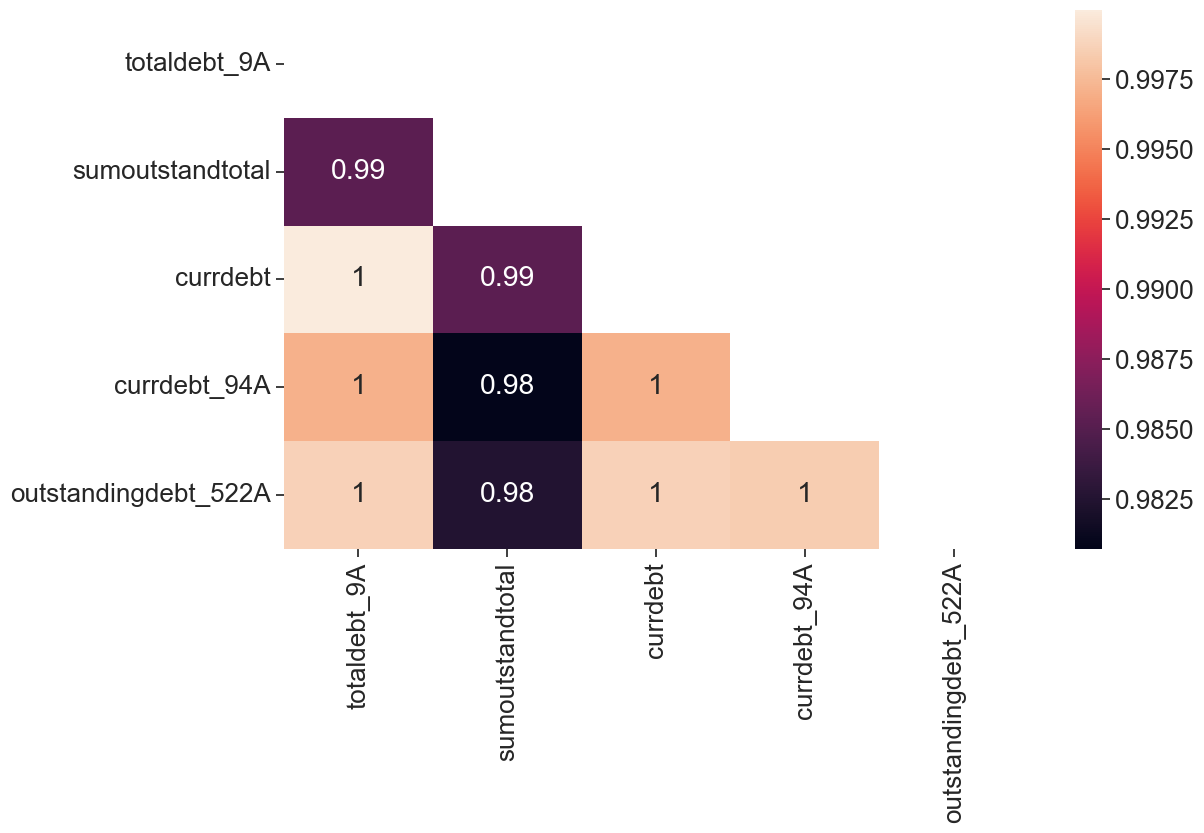

In [133]:
df = (
    lf.select(
        "totaldebt_9A",
        "sumoutstandtotal",
        "currdebt",
        "currdebt_94A",
        "outstandingdebt_522A",
    )
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

In [134]:
lf.select(
    "totaldebt_9A",
    "sumoutstandtotal",
    "currdebt",
    "currdebt_94A",
    "outstandingdebt_522A",
).describe()

shape: (9, 6)
┌────────────┬──────────────┬──────────────────┬──────────────┬──────────────┬──────────────────────┐
│ statistic  ┆ totaldebt_9A ┆ sumoutstandtotal ┆ currdebt     ┆ currdebt_94A ┆ outstandingdebt_522A │
│ ---        ┆ ---          ┆ ---              ┆ ---          ┆ ---          ┆ ---                  │
│ str        ┆ f64          ┆ f64              ┆ f64          ┆ f64          ┆ f64                  │
╞════════════╪══════════════╪══════════════════╪══════════════╪══════════════╪══════════════════════╡
│ count      ┆ 1.526656e6   ┆ 1.526659e6       ┆ 1.526659e6   ┆ 1.107653e6   ┆ 1.106276e6           │
│ null_count ┆ 3.0          ┆ 0.0              ┆ 0.0          ┆ 419006.0     ┆ 420383.0             │
│ mean       ┆ 19683.115099 ┆ 19606.628123     ┆ 19682.373007 ┆ 18619.466361 ┆ 25082.242833         │
│ std        ┆ 50836.034256 ┆ 50737.85583      ┆ 50835.235344 ┆ 34616.986488 ┆ 53628.362887         │
│ min        ┆ 0.0          ┆ -25044.0         ┆ 0.0          ┆ 0.0          ┆ 0.0                  │
│ 25%        ┆ 0.0          ┆ 0.0              ┆ 0.0          ┆ 0.0          ┆ 0.0                  │
│ 50%        ┆ 0.0          ┆ 0.0              ┆ 0.0          ┆ 0.0          ┆ 0.0                  │
│ 75%        ┆ 13493.0      ┆ 13263.0          ┆ 13492.0      ┆ 22726.822    ┆ 25373.8              │
│ max        ┆ 1210629.1    ┆ 1.210629e6       ┆ 1210629.1    ┆ 507429.72    ┆ 1210629.1            │
└────────────┴──────────────┴──────────────────┴──────────────┴──────────────┴──────────────────────┘

- totaldebt_9A,Total amount of debt.
- currdebt_94A,Previous application's current debt.
- outstandingdebt_522A,Amount of outstanding debt on the client's previous application.
- sumoutstandtotal - Sum of total outstanding amount.
- currdebt - Current debt amount of the client.
- Эти 5 признаов можно объединить в debt_outstand_total

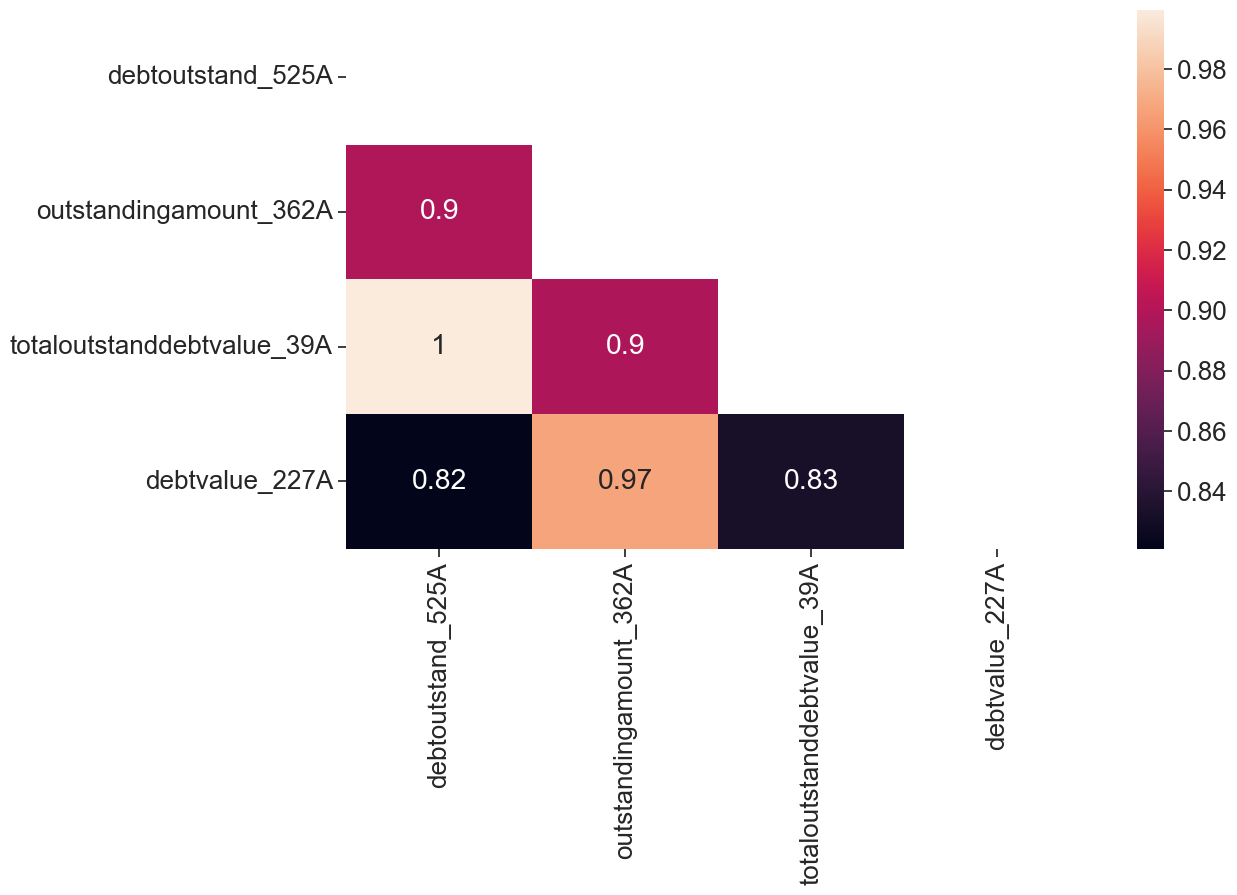

In [48]:
df = (
    lf.select(
        "debtoutstand_525A",
        "outstandingamount_362A",
        "totaloutstanddebtvalue_39A",
        "debtvalue_227A",
    )
    .collect()
    .to_pandas()
)
plot_corr_heatmap(df)

In [94]:
lf.select(
    "numberofoverdueinstlmax_1039L", "pmts_overdue_1140A", "pmts_pmtsoverdue_635A"
).describe()

shape: (9, 4)
┌────────────┬───────────────────────────────┬────────────────────┬───────────────────────┐
│ statistic  ┆ numberofoverdueinstlmax_1039L ┆ pmts_overdue_1140A ┆ pmts_pmtsoverdue_635A │
│ ---        ┆ ---                           ┆ ---                ┆ ---                   │
│ str        ┆ f64                           ┆ f64                ┆ f64                   │
╞════════════╪═══════════════════════════════╪════════════════════╪═══════════════════════╡
│ count      ┆ 1.264006e6                    ┆ 1.264006e6         ┆ 36415.0               │
│ null_count ┆ 262653.0                      ┆ 262653.0           ┆ 1.490244e6            │
│ mean       ┆ 30.422193                     ┆ 5567.940839        ┆ 36.426704             │
│ std        ┆ 219.812175                    ┆ 567085.886437      ┆ 1547.789956           │
│ min        ┆ 0.0                           ┆ 0.0                ┆ 0.0                   │
│ 25%        ┆ 0.0                           ┆ 0.0                ┆ 0.0                   │
│ 50%        ┆ 0.0                           ┆ 0.0                ┆ 0.0                   │
│ 75%        ┆ 7.0                           ┆ 1694.994           ┆ 2.6000001             │
│ max        ┆ 61133.0                       ┆ 4.373397e8         ┆ 147470.61             │
└────────────┴───────────────────────────────┴────────────────────┴───────────────────────┘

- debtoutstand_525A, Outstanding amount of existing contract. (Непогашенная сумма существующего контракта)
- outstandingamount_362A,Active contract's outstanding amount. (Непогашенная сумма активного контракта.)
- totaloutstanddebtvalue_39A,Total outstanding debt for active contracts in the credit bureau. (Общая непогашенная задолженность по действующим договорам в кредитном бюро.)
- debtvalue_227A,Outstanding amount for existing debt contracts. (Непогашенная сумма по существующим долговым контрактам.)
- Эти 4 признака агрегируем в один.

In [156]:
ds = Dataset()
lf = ds.generate_data()
lf.width

242

После всех объединений колонок на основе анализа коэффициентов корреляции сокращаем кол-во колонок до 242.

## Доля пропусков

Проверим заполненность признаков.

In [12]:
def show_misses_lf(lf: pl.LazyFrame) -> None:
    """
    Prints the proportion of gaps for each column in LazyFrame.

    Parameters
    ----------
    lf: pl.LazyFrame

    Returns
    -------
    None
    """
    n_rows = lf.select(pl.len()).collect().item()
    for col in tqdm(sorted(lf.columns)):
        n_misses = lf.select(col).null_count().collect().item()
        if n_misses == 0:
            continue
        print("%s = %s %%" % (col, round(n_misses * 100 / n_rows, 2)))

In [4]:
ds = Dataset()
lf = ds.generate_data()

In [10]:
show_misses_lf(lf)

  0%|          | 0/242 [00:00<?, ?it/s]

active_contract_end_date_days_ago = 17.01 %
amount_416A = 93.11 %
amtdebitincoming_4809443A = 96.65 %
amtdebitoutgoing_4809440A = 96.65 %
amtdepositbalance_4809441A = 96.65 %
amtdepositincoming_4809444A = 96.65 %
amtdepositoutgoing_4809442A = 96.65 %
annuity_853A = 20.22 %
annuitynextmonth_57A = 0.0 %
avgdbdtollast24m_4525197P = 63.72 %
avginstallast24m_3658937A = 40.93 %
avgoutstandbalancel6m_4187114A = 55.1 %
cacccardblochreas_147M = 21.59 %
cancelreason_3545846M = 19.99 %
classificationofcontr_1114M = 97.61 %
classificationofcontr_13M = 9.2 %
classificationofcontr_400M = 9.2 %
collaterals_typeofguarante_359M = 9.26 %
collaterals_typeofguarante_669M = 9.26 %
contractdate_551D = 97.61 %
contractenddate_991D = 96.09 %
contractst_516M = 97.61 %
contractst_545M = 9.2 %
contractst_964M = 9.2 %
contracttype_653M = 97.61 %
cred_closure_date_days_ago = 33.58 %
credacc_actualbalance_314A = 83.39 %
credacc_cards_status_52L = 83.55 %
credacc_credlmt_575A = 20.14 %
credamount_590A = 20.14 %
cred

Признаки с высокой степенью пропусков объединим с похожими или удалим.

In [233]:
ds = Dataset()
lf = ds.generate_data()
lf.width

199

В итоге сократили количество колонок с 488 до 196 только объединив схожие признаки по смыслу и значениям и удалив признаки с большим количеством пропусков. Далее попробуем сократить количество признаков с помощью feature selection.

## Заполнение пропусков

Проверим какой метод заполнения пропусков для числовых данных лучше. Для категориальных выберем заполнение константой 'None'.

In [6]:
ds = Dataset()

In [7]:
df = ds.get_dataframe()
df_p = df.to_pandas()

  0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
X = df_p.drop(["WEEK_NUM", "case_id", "target"], axis=1)
y = df_p["target"]
weeks = df_p["WEEK_NUM"]
aucs = {}

In [13]:
def cross_val(X: pd.DataFrame, y: np.ndarray, weeks: pl.Series) -> tuple:
    """
    Cross validate catboost using AUC metric.

    Parameters
    ----------
    X: pd.DataFrame
    y: np.ndarray
    weeks: pl.Series
        Using for cv groups

    Returns
    -------
    out: tuple
        mean auc score, std of auc score
    """
    cv = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    auc_scores = np.empty(N_FOLDS)
    cat_features = X.select_dtypes(object).columns.tolist()
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=weeks)):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_val_cv = y[train_idx], y[test_idx]
        scale_pos_weight = float(np.sum(y_train_cv == 0)) / np.sum(y_train_cv == 1)
        eval_set = [(X_val_cv, y_val_cv)]
        model = CatBoostClassifier(
            eval_metric="AUC",
            random_state=RAND,
            scale_pos_weight=scale_pos_weight,
            cat_features=cat_features,
            task_type="GPU",
        )

        model.fit(
            X_train_cv,
            y_train_cv,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=0,
        )

        y_score = model.predict_proba(X_val_cv)
        auc_scores[idx] = roc_auc_score(y_val_cv, y_score[:, 1])
        print(f"Fold {idx} ROC AUC = {auc_scores[idx]:.4f}")
    return np.mean(auc_scores), np.std(auc_scores)

In [36]:
cat_features = X.select_dtypes(object).columns.tolist()
imputer_cat = SimpleImputer(missing_values=None, strategy="constant", fill_value="None")
X_cat = imputer_cat.fit_transform(X[cat_features], y)
X[cat_features] = X_cat

### Baseline with NaNs

In [56]:
auc_orig, std_orig = cross_val(X, y, weeks)

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 ROC AUC = 0.8559


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 ROC AUC = 0.8557


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 ROC AUC = 0.8473


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 ROC AUC = 0.8539


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 ROC AUC = 0.8517


In [57]:
aucs["Baseline NaN"] = (auc_orig, std_orig)
aucs

{'Baseline NaN': (0.8528996966400278, 0.0031628357108856565)}

### Replace missing values by 0 and None

In [ ]:
X_zero = X.copy()
for col in tqdm(X_zero.columns):
    n_na = sum(X_zero[col].isna())
    if n_na > 0 and X_zero[col].dtype == object:
        X_zero[col].fillna("None", inplace=True)
    elif n_na > 0 and X_zero[col].dtype == bool:
        X_zero[col].fillna(False, inplace=True)
    elif n_na > 0:
        X_zero[col].fillna(0, inplace=True)

In [59]:
X_zero

month_decision  weekday_decision  days30_165L  maritalst_385M  \
0                     1                 4          0.0             0.0   
1                     1                 4          0.0             0.0   
2                     1                 5          0.0             0.0   
3                     1                 4          0.0             0.0   
4                     1                 5          0.0             0.0   
...                 ...               ...          ...             ...   
1526654              10                 1          0.0             2.0   
1526655              10                 1          0.0             2.0   
1526656              10                 1          0.0             2.0   
1526657              10                 1          1.0             0.0   
1526658              10                 1          0.0             4.0   

         pmtscount_423L requesttype_4525192L  amtinstpaidbefduel24m_4187115A  \
0                   0.0                 None                             0.0   
1                   0.0                 None                             0.0   
2                   0.0                 None                             0.0   
3                   0.0                 None                             0.0   
4                   0.0                 None                             0.0   
...                 ...                  ...                             ...   
1526654             0.0                 None                        176561.0   
1526655             0.0                 None                        301276.0   
1526656             0.0                 None                         14232.0   
1526657             0.0                 None                        197371.0   
1526658             0.0                 None                         82949.0   

         annuity_780A  annuitynextmonth_57A  avginstallast24m_3658937A  ...  \
0           1917.6000                   0.0                     0.0000  ...   
1           3134.0000                   0.0                     0.0000  ...   
2           4937.0000                   0.0                     0.0000  ...   
3           4643.6000                   0.0                     0.0000  ...   
4           3390.2000                   0.0                     0.0000  ...   
...               ...                   ...                        ...  ...   
1526654     3675.4001                   0.0                  7356.8003  ...   
1526655     7088.6000                6191.6                 12553.2000  ...   
1526656     7788.8003                   0.0                  2662.4001  ...   
1526657     1195.4000                2827.2                  8212.6010  ...   
1526658     4533.8003                2986.8                  6405.4000  ...   

         purposeofcred_active  residualamount_closed  subjectrole_active  \
0                        None                    0.0                None   
1                        None                    0.0                None   
2                        None                    0.0                None   
3                        None                    0.0                None   
4                        None                    0.0                None   
...                       ...                    ...                 ...   
1526654              a55475b1                    0.0            a55475b1   
1526655              a55475b1                    0.0            a55475b1   
1526656              a55475b1                    0.0            a55475b1   
1526657              a55475b1                    0.0            a55475b1   
1526658              a55475b1                    0.0            a55475b1   

         subjectrole_closed      empladdr  num_total_inst num_total_paid_inst  \
0                      None  P167_100_165             0.0                 0.0   
1                      None    P49_46_174             0.0                 0.0   
2                      None     P63_14_24             

In [60]:
auc_zero, std_zero = cross_val(X_zero, y, weeks)

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 ROC AUC = 0.8552


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 ROC AUC = 0.8549


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 ROC AUC = 0.8462


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 ROC AUC = 0.8528


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 ROC AUC = 0.8516


In [61]:
aucs["Zero imputation"] = (auc_zero, std_zero)
aucs

{'Baseline NaN': (0.8528996966400278, 0.0031628357108856565),
 'Zero imputation': (0.8521540964537808, 0.003273402005788499)}

### Simple Impute missing values float as mean, int as 0

In [62]:
int_columns = X.select_dtypes(int).columns.tolist()
imputer_int = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
X_int = imputer_int.fit_transform(X[int_columns], y)
X_int = pd.DataFrame(X_int, columns=int_columns)

In [63]:
float_cols = X.select_dtypes(float).columns.tolist()
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
X_mean = imputer.fit_transform(X[float_cols], y)
X_mean = pd.DataFrame(X_mean, columns=float_cols)

In [65]:
X_mean_zero = pd.concat([X_mean, X[cat_features], X_int], axis=1)

In [66]:
X_mean_zero

days30_165L  maritalst_385M  pmtscount_423L  \
0           0.517708        1.466548        5.839291   
1           0.517708        1.466548        5.839291   
2           0.517708        1.466548        5.839291   
3           0.517708        1.466548        5.839291   
4           0.517708        1.466548        5.839291   
...              ...             ...             ...   
1526654     0.000000        2.000000        5.839291   
1526655     0.000000        2.000000        5.839291   
1526656     0.000000        2.000000        5.839291   
1526657     1.000000        0.000000        5.839291   
1526658     0.000000        4.000000        5.839291   

         amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                          55957.974373     1917.6000                   0.0   
1                          55957.974373     3134.0000                   0.0   
2                          55957.974373     4937.0000                   0.0   
3                          55957.974373     4643.6000                   0.0   
4                          55957.974373     3390.2000                   0.0   
...                                 ...           ...                   ...   
1526654                   176561.000000     3675.4001                   0.0   
1526655                   301276.000000     7088.6000                6191.6   
1526656                    14232.000000     7788.8003                   0.0   
1526657                   197371.000000     1195.4000                2827.2   
1526658                    82949.000000     4533.8003                2986.8   

         avginstallast24m_3658937A  avgoutstandbalancel6m_4187114A  \
0                      5401.587636                    45984.826804   
1                      5401.587636                    45984.826804   
2                      5401.587636                    45984.826804   
3                      5401.587636                    45984.826804   
4                      5401.587636                    45984.826804   
...                            ...                             ...   
1526654                7356.800300                    16392.496000   
1526655               12553.200000                   105129.310000   
1526656                2662.400100                    45984.826804   
1526657                8212.601000                    47943.062000   
1526658                6405.400000                    15651.796000   

         cntincpaycont9m_3716944L  cntpmts24_3658933L  ...      empladdr  \
0                        6.190625           10.630644  ...  P167_100_165   
1                        6.190625           10.630644  ...    P49_46_174   
2                        6.190625           10.630644  ...     P63_14_24   
3                        6.190625           10.630644  ...   P161_14_174   
4                        6.190625           10.630644  ...      P8_88_79   
...                           ...                 ...  ...           ...   
1526654                 15.000000           24.000000  ...      a55475b1   
1526655                 17.000000           21.000000  ...      a55475b1   
1526656                  0.000000            7.000000  ...      a55475b1   
1526657                  7.000000           23.000000  ...      a55475b1   
1526658                 10.000000           14.000000  ...      a55475b1   

         applicationcnt_for_client  applicationcnt_for_empl  num_active_creds  \
0                                0                        0                 0   
1                                0                        0                 0   
2                                0                        0                 0   
3                                1                        2                 0   
4                                1                        0                 0   
...                            ...                      ...               ...   
1526654                         10                        0       

In [67]:
auc_mean_zero, std_mean_zero = cross_val(X_mean_zero, y, weeks)
aucs["Impute mean-zero-None"] = (auc_mean_zero, std_mean_zero)
aucs

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 ROC AUC = 0.8551


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 ROC AUC = 0.8535


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 ROC AUC = 0.8464


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 ROC AUC = 0.8525


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 ROC AUC = 0.8496


{'Baseline NaN': (0.8528996966400278, 0.0031628357108856565),
 'Zero imputation': (0.8521540964537808, 0.003273402005788499),
 'Impute mean-zero-None': (0.8514434800546894, 0.003073634348039875)}

### Simple Impute missing values float as median, int as 0

In [68]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X_median = imputer.fit_transform(X[float_cols], y)
X_median = pd.DataFrame(X_median, columns=float_cols)

In [69]:
X_median_zero = pd.concat([X_median, X[cat_features], X_int], axis=1)

In [70]:
X_median_zero

days30_165L  maritalst_385M  pmtscount_423L  \
0                0.0             2.0             6.0   
1                0.0             2.0             6.0   
2                0.0             2.0             6.0   
3                0.0             2.0             6.0   
4                0.0             2.0             6.0   
...              ...             ...             ...   
1526654          0.0             2.0             6.0   
1526655          0.0             2.0             6.0   
1526656          0.0             2.0             6.0   
1526657          1.0             0.0             6.0   
1526658          0.0             4.0             6.0   

         amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
0                               29758.0     1917.6000                   0.0   
1                               29758.0     3134.0000                   0.0   
2                               29758.0     4937.0000                   0.0   
3                               29758.0     4643.6000                   0.0   
4                               29758.0     3390.2000                   0.0   
...                                 ...           ...                   ...   
1526654                        176561.0     3675.4001                   0.0   
1526655                        301276.0     7088.6000                6191.6   
1526656                         14232.0     7788.8003                   0.0   
1526657                        197371.0     1195.4000                2827.2   
1526658                         82949.0     4533.8003                2986.8   

         avginstallast24m_3658937A  avgoutstandbalancel6m_4187114A  \
0                        4068.6000                      22754.5915   
1                        4068.6000                      22754.5915   
2                        4068.6000                      22754.5915   
3                        4068.6000                      22754.5915   
4                        4068.6000                      22754.5915   
...                            ...                             ...   
1526654                  7356.8003                      16392.4960   
1526655                 12553.2000                     105129.3100   
1526656                  2662.4001                      22754.5915   
1526657                  8212.6010                      47943.0620   
1526658                  6405.4000                      15651.7960   

         cntincpaycont9m_3716944L  cntpmts24_3658933L  ...      empladdr  \
0                             5.0                10.0  ...  P167_100_165   
1                             5.0                10.0  ...    P49_46_174   
2                             5.0                10.0  ...     P63_14_24   
3                             5.0                10.0  ...   P161_14_174   
4                             5.0                10.0  ...      P8_88_79   
...                           ...                 ...  ...           ...   
1526654                      15.0                24.0  ...      a55475b1   
1526655                      17.0                21.0  ...      a55475b1   
1526656                       0.0                 7.0  ...      a55475b1   
1526657                       7.0                23.0  ...      a55475b1   
1526658                      10.0                14.0  ...      a55475b1   

         applicationcnt_for_client  applicationcnt_for_empl  num_active_creds  \
0                                0                        0                 0   
1                                0                        0                 0   
2                                0                        0                 0   
3                                1                        2                 0   
4                                1                        0                 0   
...                            ...                      ...               ...   
1526654                         10                        0       

In [71]:
auc_med, std_med = cross_val(X_median_zero, y, weeks)
aucs["Impute median-zero-None"] = (auc_med, std_med)
aucs

Default metric period is 5 because AUC is/are not implemented for GPU


Fold 0 ROC AUC = 0.8545


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 1 ROC AUC = 0.8539


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 2 ROC AUC = 0.8461


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 3 ROC AUC = 0.8521


Default metric period is 5 because AUC is/are not implemented for GPU


Fold 4 ROC AUC = 0.8500


{'Baseline NaN': (0.8528996966400278, 0.0031628357108856565),
 'Zero imputation': (0.8521540964537808, 0.003273402005788499),
 'Impute mean-zero-None': (0.8514434800546894, 0.003073634348039875),
 'Impute median-zero-None': (0.8513256568193761, 0.0030678899223590904)}

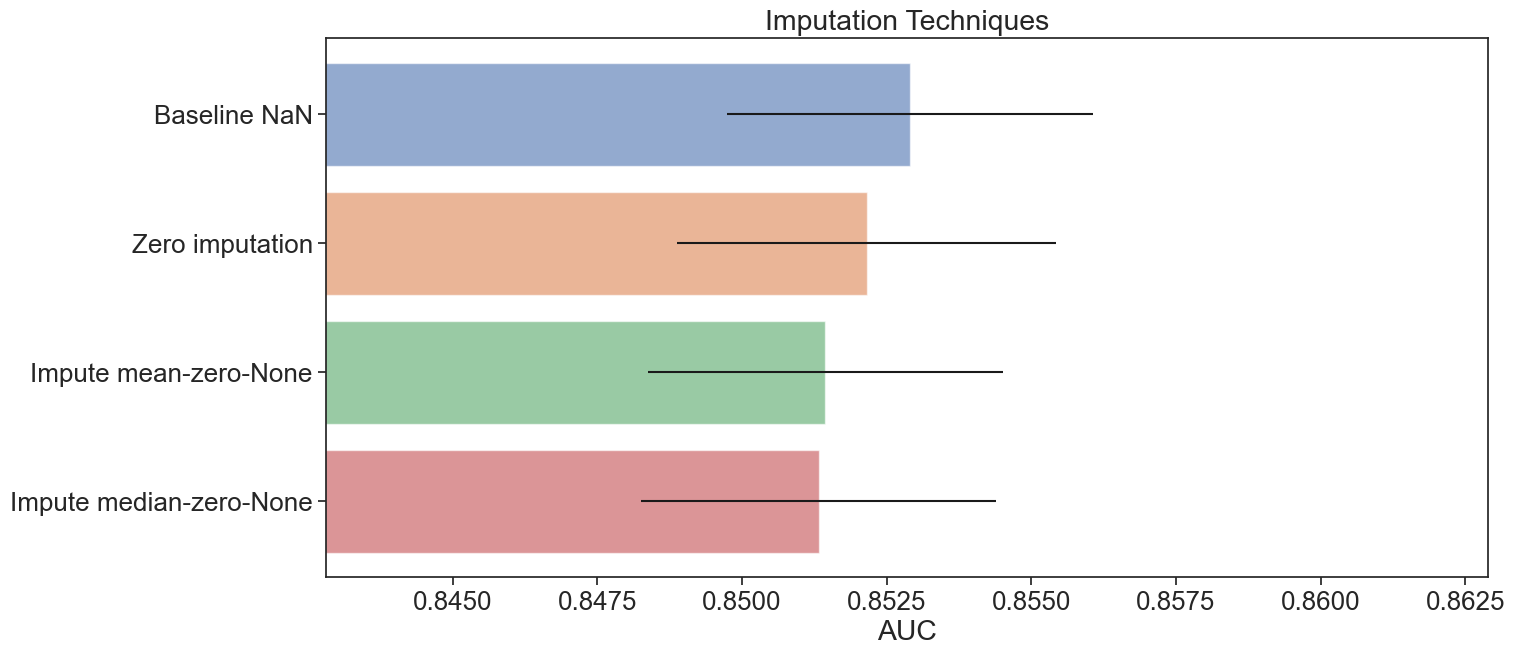

In [72]:
n_bars = len(aucs)
xval = np.arange(n_bars)
colors = ["r", "g", "b", "orange", "black"]
# plot diabetes results
fig, ax = plt.subplots(figsize=(15, 7))
for j, (m, s) in aucs.items():
    ax.barh(
        j,
        m,
        xerr=s,
        alpha=0.6,
        align="center",
    )

ax.set_title("Imputation Techniques")
means = [m for m, s in aucs.values()]
min_val = np.min(means)
max_val = np.max(means)
ax.set_xlim(left=min_val * 0.99, right=max_val + 0.01)
ax.set_xlabel("AUC")
ax.invert_yaxis()

plt.show()

Лучшие результаты получили просто при замене в категориальных признаках None на 'None'. Пропуски в числовых признаках так и оставим.

## Вывод

С помощью анализа корреляции признаков нашли схожие по смыслу и значениям, которые можно объединить в один признак. Удалили признаки с высокой долей пропусков. Нашли наиболее подходящий способ заполнения пропусков.
В итоге смогли сократить количество признаков с 290 до 192.

# Feature selection

In [ ]:
ds = Dataset()
df = ds.get_dataframe()

In [5]:
df_p = df.to_pandas()

In [6]:
X = df_p.drop(["WEEK_NUM", "case_id", "target"], axis=1)
y = df_p["target"]

## VarianceThreshold

In [8]:
X_num = X._get_numeric_data()
print(X_num.columns.shape)
selector = VarianceThreshold()
selector.fit_transform(X_num, y).shape

(142,)


(1526659, 140)

In [11]:
df_var = pd.DataFrame(
    {"feature": selector.feature_names_in_, "variances": selector.variances_}
)
df_var.sort_values(by="variances")

feature     variances
14           deferredmnthsnum_166L  0.000000e+00
12        commnoinclast6m_3546845L  0.000000e+00
42      posfpd30lastmonth_3976960P  7.984558e-03
41          posfpd10lastmonth_333P  1.587358e-02
32           numnotactivated_1143L  2.474378e-02
..                             ...           ...
90        max_overdueamount_closed  6.392341e+11
133  total_amount_closed_contracts  1.867763e+12
134  total_amount_active_contracts  4.510183e+12
126    outstand_amount_debt_active  4.571525e+12
123                   credlmt_actv  3.038022e+13

[142 rows x 2 columns]

In [13]:
feature_names_out = selector.get_feature_names_out(X_num.columns)

In [14]:
low_variance_features = set(feature_names_out) ^ set(X_num.columns)
print(f"{len(low_variance_features)} of {len(X_num.columns)}")
low_variance_features

2 of 142


{'commnoinclast6m_3546845L', 'deferredmnthsnum_166L'}

Выявили 2 признака с нулевой вариативностью, эти признаки исключим.

## SelectKBest

In [75]:
X_zero.shape

(1526659, 193)

In [76]:
X_num = X_zero._get_numeric_data()
print(X_num.columns.shape)
selector = SelectKBest(k=100)
X_kbest = selector.fit_transform(X_num, y)
X_kbest.shape

(140,)


(1526659, 100)

In [77]:
df_kbest = pd.DataFrame(
    {
        "feature": selector.feature_names_in_,
        "scores_": selector.scores_,
        "pvalues": selector.pvalues_,
    }
)
df_kbest.sort_values(by="pvalues")

feature      scores_   pvalues
56                 num_overdue_paid_inst  6392.168071  0.000000
48                             maxdbddpd  1943.449734  0.000000
66                           dpdmax_139P  2842.464293  0.000000
131          avg_days_before_or_past_due  2443.721754  0.000000
27                     mobilephncnt_593L  5293.654248  0.000000
..                                   ...          ...       ...
137           cred_closure_date_days_ago     1.124701  0.288909
121                         debt_overdue     0.216622  0.641626
101  total_outstand_amount_closed_credit     0.216590  0.641651
134                residualamount_closed     0.181083  0.670444
130                        education_max     0.020250  0.886842

[140 rows x 3 columns]

Выберем признаки у которых pvalue > 0.05

In [78]:
df_kbest[df_kbest.pvalues > 0.05].sort_values(by="pvalues")

feature   scores_   pvalues
59                  credacc_credlmt_575A  1.976723  0.159736
69               monthlyinstlamount_332A  1.831055  0.176003
117                       credlmt_closed  1.777431  0.182465
86              max_overdueamount_active  1.596589  0.206388
81           overdueamountmax2date_1142D  1.508381  0.219386
98                    pmts_overdue_1140A  1.280702  0.257769
118                         credlmt_actv  1.195279  0.274267
137           cred_closure_date_days_ago  1.124701  0.288909
121                         debt_overdue  0.216622  0.641626
101  total_outstand_amount_closed_credit  0.216590  0.641651
134                residualamount_closed  0.181083  0.670444
130                        education_max  0.020250  0.886842

Выделили 12 потенциальных признаков для исключения.

## Recursive feature elimination

In [98]:
cat_features = X.select_dtypes(object).columns.tolist()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND
)

scale_pos_weight = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

In [80]:
eval_set = [(X_val, y_val)]
model = CatBoostClassifier(
    eval_metric="AUC",
    random_state=RAND,
    scale_pos_weight=scale_pos_weight,
    cat_features=cat_features,
    task_type="GPU",
    iterations=1_000,
)

In [82]:
X_train.shape

(1221327, 193)

In [83]:
rfe_dict = model.select_features(
    X=X_train,
    y=y_train,
    eval_set=eval_set,
    features_for_select=X_train.columns,
    num_features_to_select=180,
    steps=13,
    train_final_model=False,
    verbose=0,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.038917
Step #1 out of 13


Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.8534870744
bestIteration = 999
Feature #56 eliminated
Step #2 out of 13
bestTest = 0.8533901572
bestIteration = 999
Feature #81 eliminated
Step #3 out of 13
bestTest = 0.8534750342
bestIteration = 999
Feature #6 eliminated
Step #4 out of 13
bestTest = 0.8536714315
bestIteration = 999
Feature #33 eliminated
Step #5 out of 13
bestTest = 0.8535636663
bestIteration = 999
Feature #98 eliminated
Step #6 out of 13
bestTest = 0.8534101248
bestIteration = 999
Feature #188 eliminated
Step #7 out of 13
bestTest = 0.8534828424
bestIteration = 999
Feature #47 eliminated
Step #8 out of 13
bestTest = 0.8534325361
bestIteration = 999
Feature #49 eliminated
Step #9 out of 13
bestTest = 0.8534058332
bestIteration = 999
Feature #48 eliminated
Step #10 out of 13
bestTest = 0.8534476757
bestIteration = 999
Feature #107 eliminated
Step #11 out of 13
bestTest = 0.8536521196
bestIteration = 999
Feature #189 eliminated
Step #12 out of 13
bestTest = 0.8535995483
bestIteration = 999
Feature #11 elim

In [84]:
rfe_dict["eliminated_features_names"]

['totalsettled_863A',
 'mainoccupationinc_437A',
 'amtinstpaidbefduel24m_4187115A',
 'maxdebt4_972A',
 'monthlyinstlamount_674A',
 'num_total_inst',
 'pctinstlsallpaidlate1d_3546856L',
 'pctinstlsallpaidlate6d_3546844L',
 'pctinstlsallpaidlate4d_3546849L',
 'numberofoverdueinstls_834L',
 'num_total_paid_inst',
 'cntincpaycont9m_3716944L',
 'role_1084L']

Видим что можно откинуть еще 3 признака без потери в качестве модели (totalsettled_863A','mainoccupationinc_437A', 'amtinstpaidbefduel24m_4187115A'). Если убирать признаки дальше, то loss value уже выше. 

## Вывод

Нашли неинформативные признаки с помощью VarianceThreshold, SelectKBest и CatBoost RFE.
В итоге количество колонок сократим с 195 до 190. Изначально было 488. Дальнейшее удаление признаков приводит к потери в качестве модели.

# Exploratory data analysis (EDA)

## Target

In [27]:
lf_base = base_table(TRAIN_PREFIX)

Посмотрим на целевую переменную **target**. Найдем соотношение классов. Из описания target - определяемое через определенный период на основе того, не выполнил ли клиент дефолт по конкретному кредитному случаю (займу).

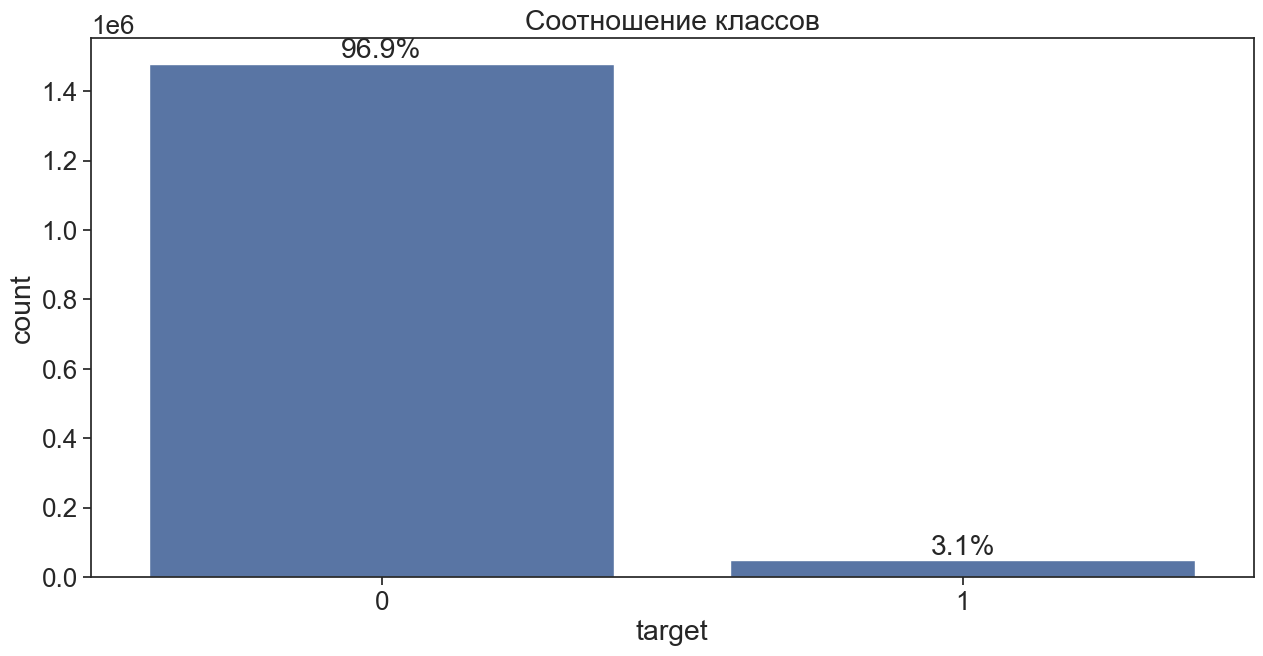

In [53]:
fig, ax = plt.subplots(figsize=(15, 7))
snl.countplot(lf_base, x="target", ax=ax)
total = lf_base.select(pl.len()).collect().item()
ax.bar_label(ax.containers[0], fmt=lambda x: f"{(x/total)*100:0.1f}%")
plt.title("Соотношение классов")
plt.show()

Наблюдаем значительный дисбаланс классов.

In [2]:
ds = Dataset()
df = ds.get_dataframe()
df_p = df.to_pandas()

  0%|          | 0/9 [00:00<?, ?it/s]

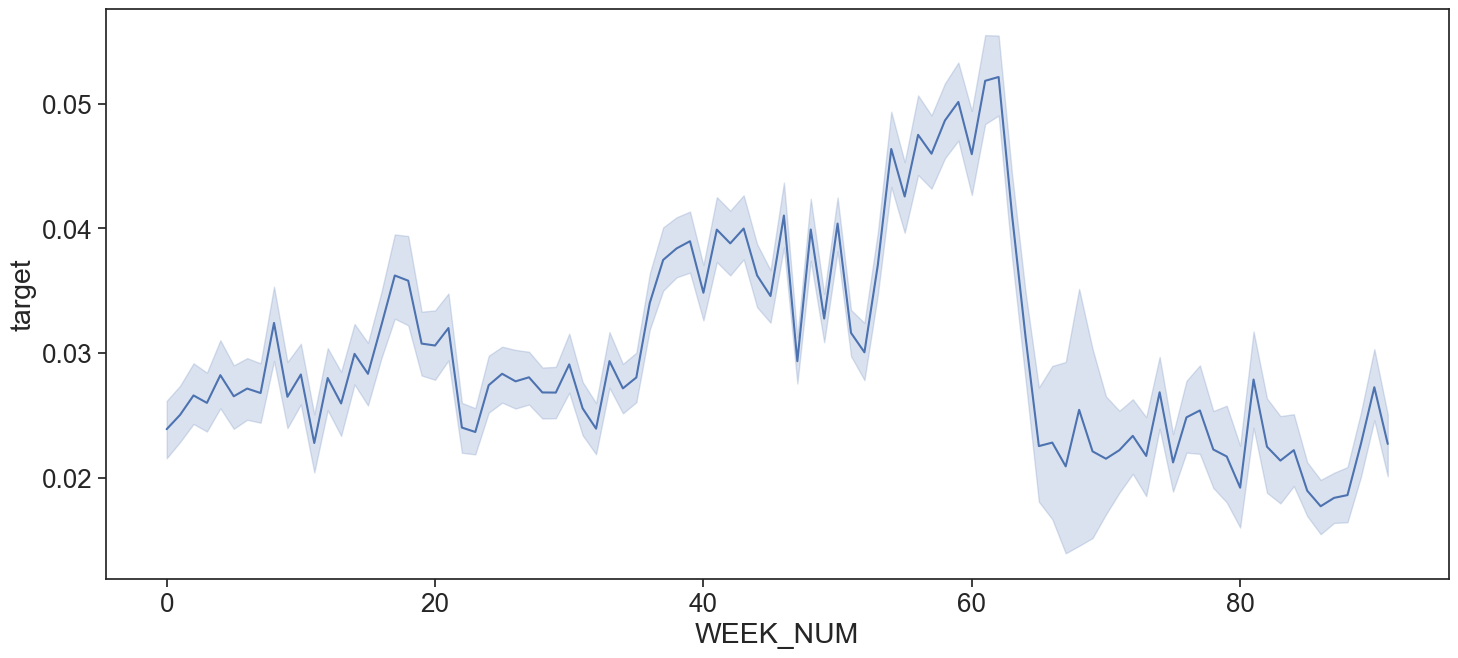

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(df_p, x="WEEK_NUM", y="target", palette="rocket", ax=ax)
plt.tight_layout()

Также видим, что соотношение классов меняется и в зависимости от недели. WEEK_NUM будем использовать для группирования в KFold.

## Гипотезы

- 1. Количество запросов в кредитное бюро за последние 360, 180, 120, 90, 30 дней отличаются для двух классов. Чем выше количество запросов тем выше вероятность дефолта по кредиту.
- 2. Количество результатов, полученных от кредитного бюро в 1-4 квартале не влияют на вероятность дефолта по кредиту. И данные признаки неинформативны.
- 3. Категоризация клиентов в кредитном бюро в целом информативна и клиенты с определенной категорией с большей вероятностью окажутся в группе 1.
- 4. Уровень образования влияет возврат кредита, также люди с высшим образованием чаще являются "хорошими" заемщиками.
- 5. Семейное положение влияет на возврат кредита.
- 6. Для "хороших" и "плохих" заемщиков отношение типов запросов налогового органа отличаются. У "плохих" тип "deduction" встречается чаще.
- 7. Количество платежей, выплаченных досрочно за последние 24 месяца является информативным признаком. Есть различия между 0 и 1 группой, причем у 1 группы количество платежей меньше.
- 8. Ежемесячная сумма платежа отличается между группами, у "хороших" заемщиков она в среднем меньше.
- 9. Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше и у "плохих" заемщиков доход внутри группы ниже.
- 10. Размер кредита (price_1097A) зависит от дохода клиента (maininc_215A), чем выше доход, тем выше размер кредита. Количество дней просрочки больше у клиентов с меньшим размером дохода.

### Гипотеза 1.

Количество запросов в кредитное бюро за последние 360, 180, 120, 90, 30 дней отличаются для двух классов. Чем выше количество запросов тем выше вероятность дефолта по кредиту.

In [217]:
ds = Dataset()
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select(
    "case_id",
    "days30_165L",
    "days90_310L",
    "days120_123L",
    "days180_256L",
    "days360_512L",
)
lf = lf_static_cb.join(lf_base, how="left", on="case_id", suffix="_base")
lf = lf.fill_null(0)

In [218]:
lf.slice(0, 10).collect()

shape: (10, 7)
┌─────────┬─────────────┬─────────────┬──────────────┬──────────────┬──────────────┬────────┐
│ case_id ┆ days30_165L ┆ days90_310L ┆ days120_123L ┆ days180_256L ┆ days360_512L ┆ target │
│ ---     ┆ ---         ┆ ---         ┆ ---          ┆ ---          ┆ ---          ┆ ---    │
│ i64     ┆ f64         ┆ f64         ┆ f64          ┆ f64          ┆ f64          ┆ i64    │
╞═════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪════════╡
│ 357     ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0      │
│ 381     ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0      │
│ 388     ┆ 2.0         ┆ 4.0         ┆ 6.0          ┆ 8.0          ┆ 10.0         ┆ 0      │
│ 405     ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 1.0          ┆ 0      │
│ 409     ┆ 0.0         ┆ 1.0         ┆ 2.0          ┆ 3.0          ┆ 3.0          ┆ 0      │
│ 410     ┆ 2.0         ┆ 2.0         ┆ 2.0          ┆ 2.0          ┆ 3.0          ┆ 0      │
│ 411     ┆ 4.0         ┆ 7.0         ┆ 9.0          ┆ 9.0          ┆ 20.0         ┆ 0      │
│ 412     ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0      │
│ 413     ┆ 0.0         ┆ 0.0         ┆ 0.0          ┆ 0.0          ┆ 0.0          ┆ 0      │
│ 414     ┆ 2.0         ┆ 2.0         ┆ 2.0          ┆ 3.0          ┆ 5.0          ┆ 0      │
└─────────┴─────────────┴─────────────┴──────────────┴──────────────┴──────────────┴────────┘

Проверим все распределения на сходство.

In [219]:
for col in [
    "days30_165L",
    "days90_310L",
    "days120_123L",
    "days180_256L",
    "days360_512L",
]:
    check_distributions_for_similarity(lf, col)

Распределение для признака days30_165L target = 1 не нормальное, pvalue = 0.0
Распределение для признака days30_165L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for days30_165L: statistic=[3.88077244e+10], p-value=[0.]
Распределение для признака days90_310L target = 1 не нормальное, pvalue = 0.0
Распределение для признака days90_310L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for days90_310L: statistic=[3.98149113e+10], p-value=[0.]
Распределение для признака days120_123L target = 1 не нормальное, pvalue = 0.0
Распределение для признака days120_123L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for days120_123L: statistic=[3.991352e+10], p-value=[0.]
Распределение для признака days180_256L target = 1 не нормальное, pvalue = 0.0
Распределение для признака days180_256L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for days180_256L: statistic=[3.98543021e+10], p-value=[0.]
Распределение для признака days360_512L target = 1 не но

Нулевая гипотеза H0 - различий в выборках нет, H1 - различия есть.
Так как p-value~0.0, отвергаем H0 и разница между выборкой c target = 0 и 1 есть и она значимая.

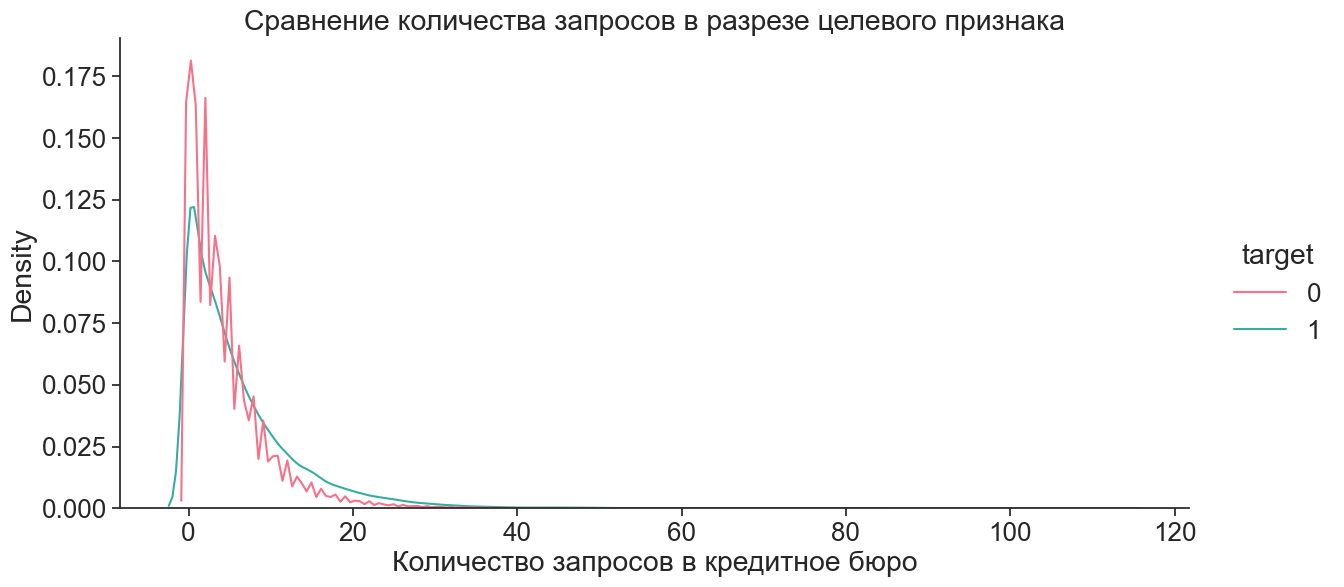

In [200]:
snl.displot(
    lf,
    x="days360_512L",
    hue="target",
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette="husl",
)
plt.title("Сравнение количества запросов в разрезе целевого признака")
plt.xlabel("Количество запросов в кредитное бюро")
plt.show()

Гипотеза подтвердилась. Количество запросов в кредитное бюро за последние 360, 180, 120, 90, 30 дней отличаются для двух классов. Чем выше количество запросов тем выше вероятность дефолта по кредиту. Это видно из графика плотности распределения. Поэтому признаки 'days30_165L', 'days90_310L', 'days120_123L', 'days180_256L', 'days360_512L' пока оставляем.

### Гипотеза 2.

Количество результатов, полученных от кредитного бюро в 1-4 квартале не влияют на вероятность дефолта по кредиту. И данные признаки неинформативны.

In [238]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select(
    "case_id",
    "firstquarter_103L",
    "secondquarter_766L",
    "thirdquarter_1082L",
    "fourthquarter_440L",
)
lf = lf_static_cb.join(lf_base, how="left", on="case_id", suffix="_base")
lf = lf.fill_null(0)

In [222]:
lf.slice(0, 10).collect()

shape: (10, 6)
┌─────────┬───────────────────┬────────────────────┬────────────────────┬────────────────────┬────────┐
│ case_id ┆ firstquarter_103L ┆ secondquarter_766L ┆ thirdquarter_1082L ┆ fourthquarter_440L ┆ target │
│ ---     ┆ ---               ┆ ---                ┆ ---                ┆ ---                ┆ ---    │
│ i64     ┆ f64               ┆ f64                ┆ f64                ┆ f64                ┆ i64    │
╞═════════╪═══════════════════╪════════════════════╪════════════════════╪════════════════════╪════════╡
│ 357     ┆ 0.0               ┆ 0.0                ┆ 0.0                ┆ 0.0                ┆ 0      │
│ 381     ┆ 0.0               ┆ 0.0                ┆ 0.0                ┆ 0.0                ┆ 0      │
│ 388     ┆ 2.0               ┆ 3.0                ┆ 5.0                ┆ 6.0                ┆ 0      │
│ 405     ┆ 0.0               ┆ 2.0                ┆ 0.0                ┆ 4.0                ┆ 0      │
│ 409     ┆ 4.0               ┆ 0.0                ┆ 4.0                ┆ 1.0                ┆ 0      │
│ 410     ┆ 2.0               ┆ 3.0                ┆ 6.0                ┆ 0.0                ┆ 0      │
│ 411     ┆ 6.0               ┆ 9.0                ┆ 2.0                ┆ 20.0               ┆ 0      │
│ 412     ┆ 0.0               ┆ 0.0                ┆ 0.0                ┆ 0.0                ┆ 0      │
│ 413     ┆ 0.0               ┆ 0.0                ┆ 0.0                ┆ 0.0                ┆ 0      │
│ 414     ┆ 2.0               ┆ 2.0                ┆ 1.0                ┆ 2.0                ┆ 0      │
└─────────┴───────────────────┴────────────────────┴────────────────────┴────────────────────┴────────┘

In [223]:
for col in [
    "firstquarter_103L",
    "secondquarter_766L",
    "thirdquarter_1082L",
    "fourthquarter_440L",
]:
    check_distributions_for_similarity(lf, col)

Распределение для признака firstquarter_103L target = 1 не нормальное, pvalue = 0.0
Распределение для признака firstquarter_103L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for firstquarter_103L: statistic=[3.68216886e+10], p-value=[0.]
Распределение для признака secondquarter_766L target = 1 не нормальное, pvalue = 0.0
Распределение для признака secondquarter_766L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for secondquarter_766L: statistic=[3.60736534e+10], p-value=[0.]
Распределение для признака thirdquarter_1082L target = 1 не нормальное, pvalue = 0.0
Распределение для признака thirdquarter_1082L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for thirdquarter_1082L: statistic=[3.55973471e+10], p-value=[0.]
Распределение для признака fourthquarter_440L target = 1 не нормальное, pvalue = 0.0
Распределение для признака fourthquarter_440L target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for fourthquarter_440L: statistic=[3.6194845

Нулевая гипотеза H0 - различий в выборках нет, H1 - различия есть.
Так как p-value~0.0, отвергаем H0 и разница между выборкой c target = 0 и 1 есть и она значимая.

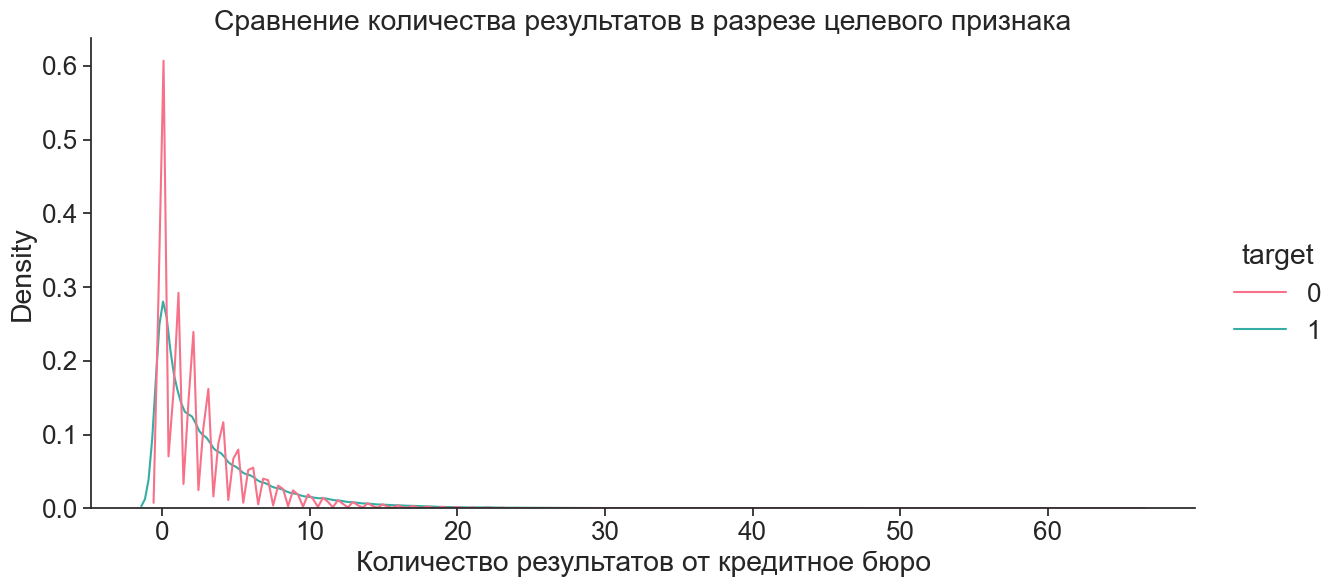

In [227]:
snl.displot(
    lf,
    x="fourthquarter_440L",
    hue="target",
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette="husl",
)
plt.title("Сравнение количества результатов в разрезе целевого признака")
plt.xlabel("Количество результатов от кредитное бюро")
plt.show()

Гипотеза 2 не подтвердилась. Количество результатов, полученных от кредитного бюро в 1-4 квартале на самом деле информативны. Попробуем объединить все 4 признака в один и суммировать значения за все кварталы. Получим количество запросов в год.

In [228]:
lf = lf.with_columns(
    pl.max_horizontal(
        "firstquarter_103L",
        "secondquarter_766L",
        "thirdquarter_1082L",
        "fourthquarter_440L",
    ).alias("number_results_year")
)
lf = lf.drop(
    "firstquarter_103L",
    "secondquarter_766L",
    "thirdquarter_1082L",
    "fourthquarter_440L",
)
lf.slice(0, 10).collect()

shape: (10, 3)
┌─────────┬────────┬─────────────────────┐
│ case_id ┆ target ┆ number_results_year │
│ ---     ┆ ---    ┆ ---                 │
│ i64     ┆ i64    ┆ f64                 │
╞═════════╪════════╪═════════════════════╡
│ 357     ┆ 0      ┆ 0.0                 │
│ 381     ┆ 0      ┆ 0.0                 │
│ 388     ┆ 0      ┆ 6.0                 │
│ 405     ┆ 0      ┆ 4.0                 │
│ 409     ┆ 0      ┆ 4.0                 │
│ 410     ┆ 0      ┆ 6.0                 │
│ 411     ┆ 0      ┆ 20.0                │
│ 412     ┆ 0      ┆ 0.0                 │
│ 413     ┆ 0      ┆ 0.0                 │
│ 414     ┆ 0      ┆ 2.0                 │
└─────────┴────────┴─────────────────────┘

In [230]:
check_distributions_for_similarity(lf, "number_results_year")

Распределение для признака number_results_year target = 1 не нормальное, pvalue = 0.0
Распределение для признака number_results_year target = 0 не нормальное, pvalue = 0.0
 Mann–Whitney U Test for number_results_year: statistic=[3.7360947e+10], p-value=[0.]


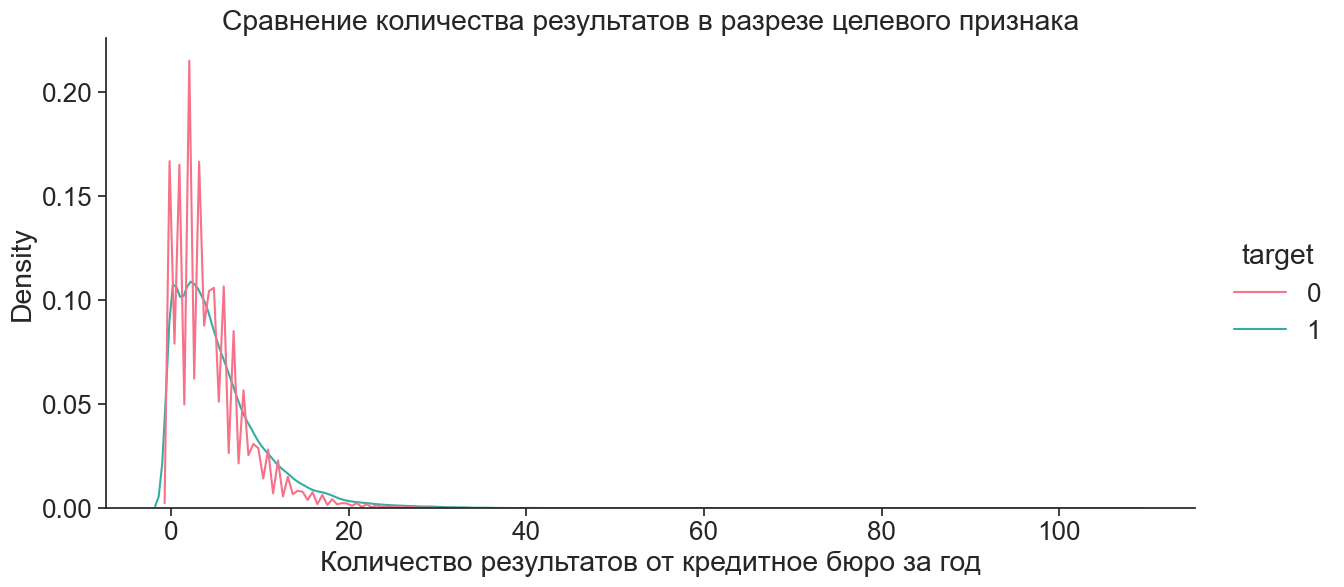

In [231]:
snl.displot(
    lf,
    x="number_results_year",
    hue="target",
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette="husl",
)
plt.title("Сравнение количества результатов в разрезе целевого признака")
plt.xlabel("Количество результатов от кредитное бюро за год")
plt.show()

Информативность не потеряли, поэтому эти 4 признака будем объединять в один.

### Гипотеза 3.

Категоризация клиентов в кредитном бюро в целом информативна и клиенты с определенной категорией с большей вероятностью окажутся в группе 1.

'description_5085714M' и 'description_351M' содержат одну и ту же информацию (Categorization of clients by credit bureau.), получим все возможные значения, и обучим OrdinalEncoder.

In [621]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select("case_id", "description_5085714M")
lf_cb_1 = scan_files(
    TRAIN_PREFIX + "credit_bureau_a_1_*.parquet",
    depth=1,
    date_col="refreshdate_3813885D",
)
lf_cb_1 = lf_cb_1.select("case_id", "description_351M")
lf = lf_static_cb.join(lf_base, how="left", on="case_id", suffix="_base")
lf = lf.join(lf_cb_1, how="left", on="case_id", suffix="_cb_1")
lf.fill_null("null")
df = lf.collect()
df

parquet_files/train\train_credit_bureau_a_1_0.parquet
parquet_files/train\train_credit_bureau_a_1_1.parquet
parquet_files/train\train_credit_bureau_a_1_2.parquet
parquet_files/train\train_credit_bureau_a_1_3.parquet


shape: (1_500_476, 4)
┌─────────┬──────────────────────┬────────┬──────────────────┐
│ case_id ┆ description_5085714M ┆ target ┆ description_351M │
│ ---     ┆ ---                  ┆ ---    ┆ ---              │
│ i64     ┆ str                  ┆ i64    ┆ str              │
╞═════════╪══════════════════════╪════════╪══════════════════╡
│ 357     ┆ a55475b1             ┆ 0      ┆ null             │
│ 381     ┆ a55475b1             ┆ 0      ┆ null             │
│ 388     ┆ a55475b1             ┆ 0      ┆ a55475b1         │
│ 405     ┆ a55475b1             ┆ 0      ┆ a55475b1         │
│ 409     ┆ a55475b1             ┆ 0      ┆ a55475b1         │
│ …       ┆ …                    ┆ …      ┆ …                │
│ 2703450 ┆ 2fc785b2             ┆ 0      ┆ a55475b1         │
│ 2703451 ┆ 2fc785b2             ┆ 0      ┆ a55475b1         │
│ 2703452 ┆ 2fc785b2             ┆ 0      ┆ a55475b1         │
│ 2703453 ┆ 2fc785b2             ┆ 0      ┆ a55475b1         │
│ 2703454 ┆ 2fc785b2             ┆ 0      ┆ a55475b1         │
└─────────┴──────────────────────┴────────┴──────────────────┘

In [622]:
df_enc = (
    lf.select("description_351M", "description_5085714M")
    .cast(pl.String)
    .unique()
    .collect()
)
uniq_values = np.unique(np.array(df_enc).ravel().astype(str))

In [623]:
description_ord_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, dtype=int
)
description_ord_enc = description_ord_enc.fit(uniq_values.reshape(-1, 1))

In [624]:
description_label_enc.classes_

array(['0349102c', '0bfbf8f5', '0cb4d552', '153cfa61', '18e98e64',
       '1d89fa48', '2fc785b2', '53179c19', '6da7c7ed', '8a7423d5',
       '95decc86', 'None', 'a55475b1', 'f8e51f8d'], dtype='<U8')

In [625]:
new_decsr = description_ord_enc.transform(
    df["description_5085714M"].to_numpy().astype(str).reshape(-1, 1)
)
new_decsr_1 = description_ord_enc.transform(
    df["description_351M"].to_numpy().astype(str).reshape(-1, 1)
)
df = df.with_columns(
    description_0=new_decsr.ravel().T, description_1=new_decsr_1.ravel().T
)
df = df.with_columns(
    pl.max_horizontal("description_0", "description_1").alias("description")
)
df = df.drop(
    "description_5085714M", "description_351M", "description_0", "description_1"
)
df

shape: (1_500_476, 3)
┌─────────┬────────┬─────────────┐
│ case_id ┆ target ┆ description │
│ ---     ┆ ---    ┆ ---         │
│ i64     ┆ i64    ┆ i32         │
╞═════════╪════════╪═════════════╡
│ 357     ┆ 0      ┆ 12          │
│ 381     ┆ 0      ┆ 12          │
│ 388     ┆ 0      ┆ 12          │
│ 405     ┆ 0      ┆ 12          │
│ 409     ┆ 0      ┆ 12          │
│ …       ┆ …      ┆ …           │
│ 2703450 ┆ 0      ┆ 12          │
│ 2703451 ┆ 0      ┆ 12          │
│ 2703452 ┆ 0      ┆ 12          │
│ 2703453 ┆ 0      ┆ 12          │
│ 2703454 ┆ 0      ┆ 12          │
└─────────┴────────┴─────────────┘

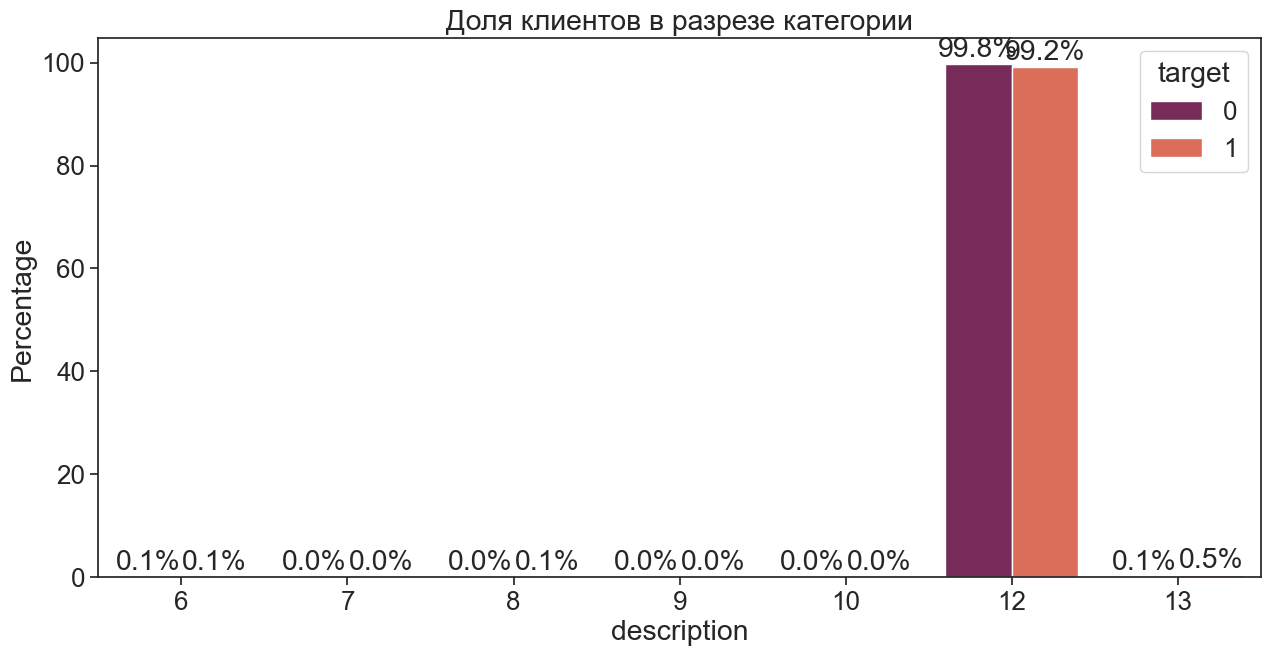

In [627]:
build_barplot_by_column(
    df.to_pandas(), "description", "Доля клиентов в разрезе категории"
)

Гипотеза не верна. Трудно сказать что категоризация клиентов в кредитном бюро информативна, т.к. обе группы в основном имеют одну категорию. Вариация очень малая, а другие категории встречаются очень редко. Приходим к выводу что этот признак неинформативен и его можно исключить.

### Гипотеза 4.

Уровень образования влияет возврат кредита, также люди с высшим образованием чаще являются "хорошими" заемщиками.

In [628]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select("case_id", "education_1103M", "education_88M")
lf = lf_base.join(lf_static_cb, how="left", on="case_id", suffix="_cb")
lf_apl = scan_files(
    TRAIN_PREFIX + "applprev_1_*.parquet", depth=1, date_col="creationdate_885D"
)
lf_apl = lf_apl.select("case_id", "education_1138M")
lf = lf.join(lf_apl, how="left", on="case_id", suffix="_apl")
lf_p = scan_file(
    TRAIN_PREFIX + "person_1.parquet", depth=1, date_col="empl_employedfrom_271D"
)
lf_p = lf_p.select("case_id", "education_927M")
lf = lf.join(lf_p, how="left", on="case_id", suffix="_per")
lf.slice(0, 10).collect()

parquet_files/train\train_applprev_1_0.parquet
parquet_files/train\train_applprev_1_1.parquet
parquet_files/train/train_person_1.parquet


shape: (10, 6)
┌─────────┬────────┬─────────────────┬───────────────┬─────────────────┬────────────────┐
│ case_id ┆ target ┆ education_1103M ┆ education_88M ┆ education_1138M ┆ education_927M │
│ ---     ┆ ---    ┆ ---             ┆ ---           ┆ ---             ┆ ---            │
│ i64     ┆ i64    ┆ str             ┆ str           ┆ str             ┆ str            │
╞═════════╪════════╪═════════════════╪═══════════════╪═════════════════╪════════════════╡
│ 0       ┆ 0      ┆ null            ┆ null          ┆ null            ┆ P97_36_170     │
│ 1       ┆ 0      ┆ null            ┆ null          ┆ null            ┆ P97_36_170     │
│ 2       ┆ 0      ┆ null            ┆ null          ┆ P97_36_170      ┆ P97_36_170     │
│ 3       ┆ 0      ┆ null            ┆ null          ┆ P97_36_170      ┆ P33_146_175    │
│ 4       ┆ 1      ┆ null            ┆ null          ┆ a55475b1        ┆ P33_146_175    │
│ 5       ┆ 0      ┆ null            ┆ null          ┆ a55475b1        ┆ P97_36_170     │
│ 6       ┆ 0      ┆ null            ┆ null          ┆ a55475b1        ┆ P97_36_170     │
│ 7       ┆ 0      ┆ null            ┆ null          ┆ null            ┆ P33_146_175    │
│ 8       ┆ 0      ┆ null            ┆ null          ┆ null            ┆ P97_36_170     │
│ 9       ┆ 0      ┆ null            ┆ null          ┆ null            ┆ a55475b1       │
└─────────┴────────┴─────────────────┴───────────────┴─────────────────┴────────────────┘

In [490]:
lf.null_count().collect()

shape: (1, 6)
┌─────────┬────────┬─────────────────┬───────────────┬─────────────────┬────────────────┐
│ case_id ┆ target ┆ education_1103M ┆ education_88M ┆ education_1138M ┆ education_927M │
│ ---     ┆ ---    ┆ ---             ┆ ---           ┆ ---             ┆ ---            │
│ u32     ┆ u32    ┆ u32             ┆ u32           ┆ u32             ┆ u32            │
╞═════════╪════════╪═════════════════╪═══════════════╪═════════════════╪════════════════╡
│ 0       ┆ 0      ┆ 26183           ┆ 26183         ┆ 305137          ┆ 0              │
└─────────┴────────┴─────────────────┴───────────────┴─────────────────┴────────────────┘

In [491]:
lf.select(pl.len()).collect().item()

1526659

- education_1103M - Level of education of the client provided by external source.
- education_1138M - Applicant's education level from their previous application.
- education_88M - Education level of the client.
- education_927M - Education level of the person.

Неизвестно что означают эти значения, так бы можно было по возрастанию закодировать. Определим какой из этих признаков наиболее информативен. Все они хорошо заполнены.

In [629]:
df_enc = (
    lf.select("education_1103M", "education_88M", "education_1138M", "education_927M")
    .cast(pl.String)
    .collect()
)
df_enc = df_enc.to_pandas()
df_enc

education_1103M education_88M education_1138M education_927M
0                  None          None            None     P97_36_170
1                  None          None            None     P97_36_170
2                  None          None      P97_36_170     P97_36_170
3                  None          None      P97_36_170    P33_146_175
4                  None          None        a55475b1    P33_146_175
...                 ...           ...             ...            ...
1526654        a55475b1      a55475b1        a55475b1       a55475b1
1526655        a55475b1      a55475b1        a55475b1       a55475b1
1526656        a55475b1      a55475b1        a55475b1       a55475b1
1526657        6b2ae0fa      a55475b1        a55475b1       a55475b1
1526658        a55475b1      a55475b1        a55475b1       a55475b1

[1526659 rows x 4 columns]

In [630]:
uniq_values = np.unique(np.array(df_enc).ravel().astype(str))
uniq_values

array(['39a0853f', '6b2ae0fa', '717ddd49', 'None', 'P106_81_188',
       'P157_18_172', 'P17_36_170', 'P33_146_175', 'P97_36_170',
       'a34a13c8', 'a55475b1', 'c8e1a1d0'], dtype='<U11')

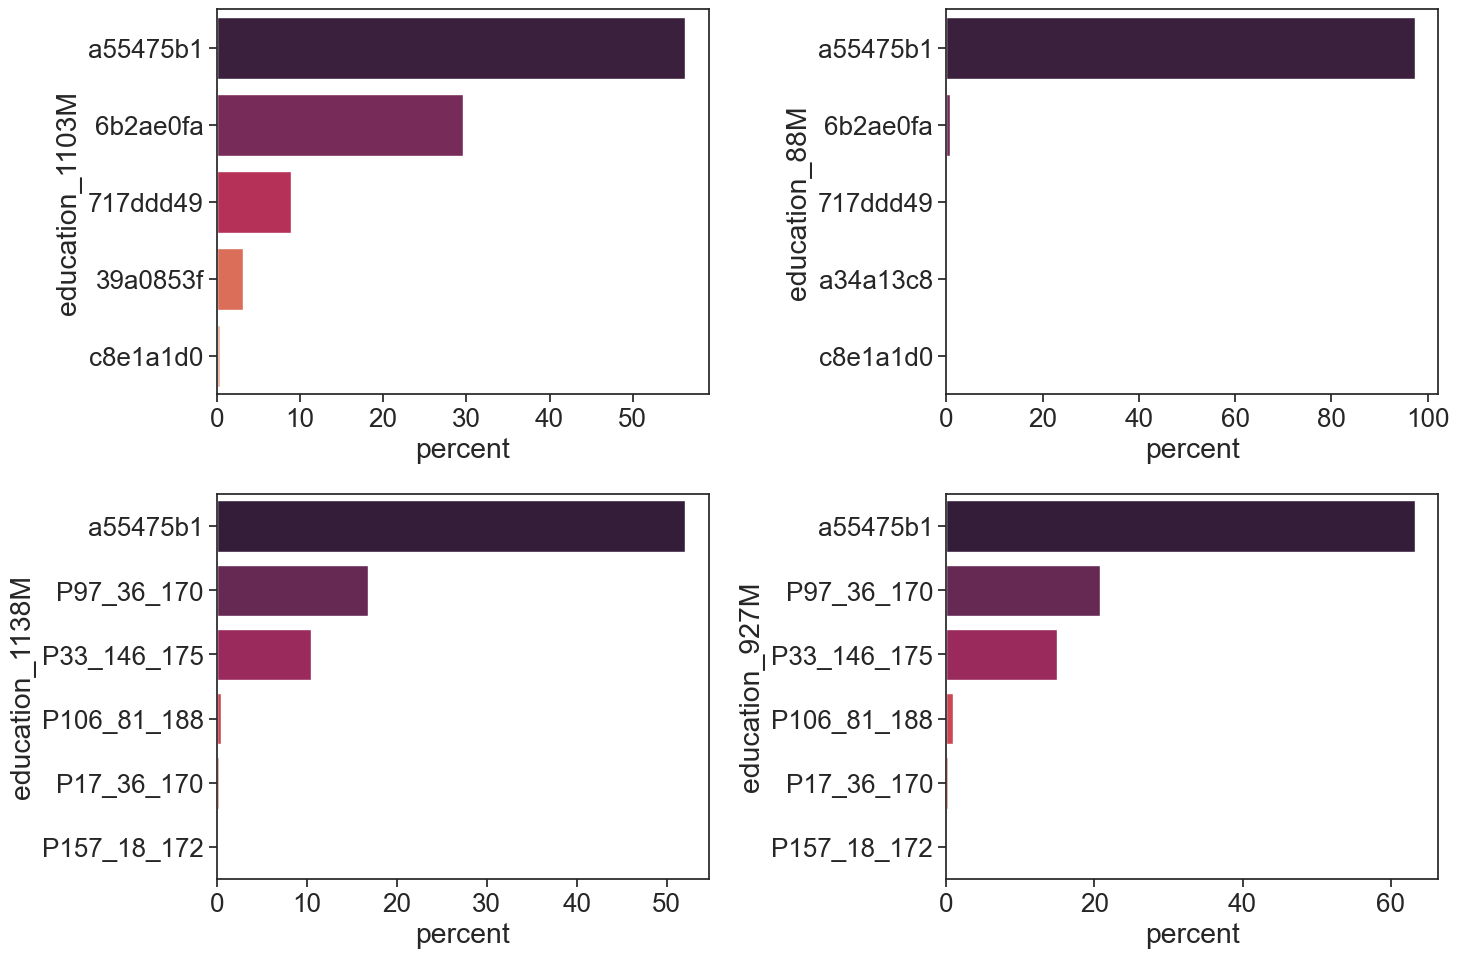

In [494]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
edu_cols = ["education_1103M", "education_88M", "education_1138M", "education_927M"]
for i, (x, y) in enumerate(list(product([0, 1], repeat=2))):
    ax = axes[x, y]
    snl.countplot(
        df_enc,
        y=edu_cols[i],
        stat="percent",
        ax=ax,
        order=df_enc[edu_cols[i]].value_counts().index,
        palette="rocket",
    )
plt.tight_layout()

Видим некоторые закономерности. Будем считать что самый популярный вид образования = a55475b1 (среднее), остальные по убыванию вероятно, высшее бакалавриат, магистратура, и тд. Можем составить примитивный ordinal encoder с помощью словаря.

In [631]:
grades = {
    "None": 1,
    "a55475b1": 1,
    "6b2ae0fa": 2,
    "P97_36_170": 2,
    "717ddd49": 3,
    "P33_146_175": 3,
    "39a0853f": 4,
    "a34a13c8": 4,
    "P106_81_188": 4,
    "c8e1a1d0": 5,
    "P17_36_170": 5,
    "P157_18_172": 6,
}

In [632]:
lf = lf.with_columns(
    pl.col("education_1103M").map_elements(lambda x: grades[x]),
    pl.col("education_88M").map_elements(lambda x: grades[x]),
    pl.col("education_1138M").map_elements(lambda x: grades[x]),
    pl.col("education_927M").map_elements(lambda x: grades[x]),
)
lf = lf.fill_null(0)
lf = lf.with_columns(pl.max_horizontal(edu_cols).alias("education"))
lf = lf.drop(edu_cols)

In [633]:
df = lf.collect()
df = df.to_pandas()
df

case_id  target  education
0              0       0          2
1              1       0          2
2              2       0          2
3              3       0          3
4              4       1          3
...          ...     ...        ...
1526654  2703450       0          1
1526655  2703451       0          1
1526656  2703452       0          1
1526657  2703453       0          2
1526658  2703454       0          1

[1526659 rows x 3 columns]

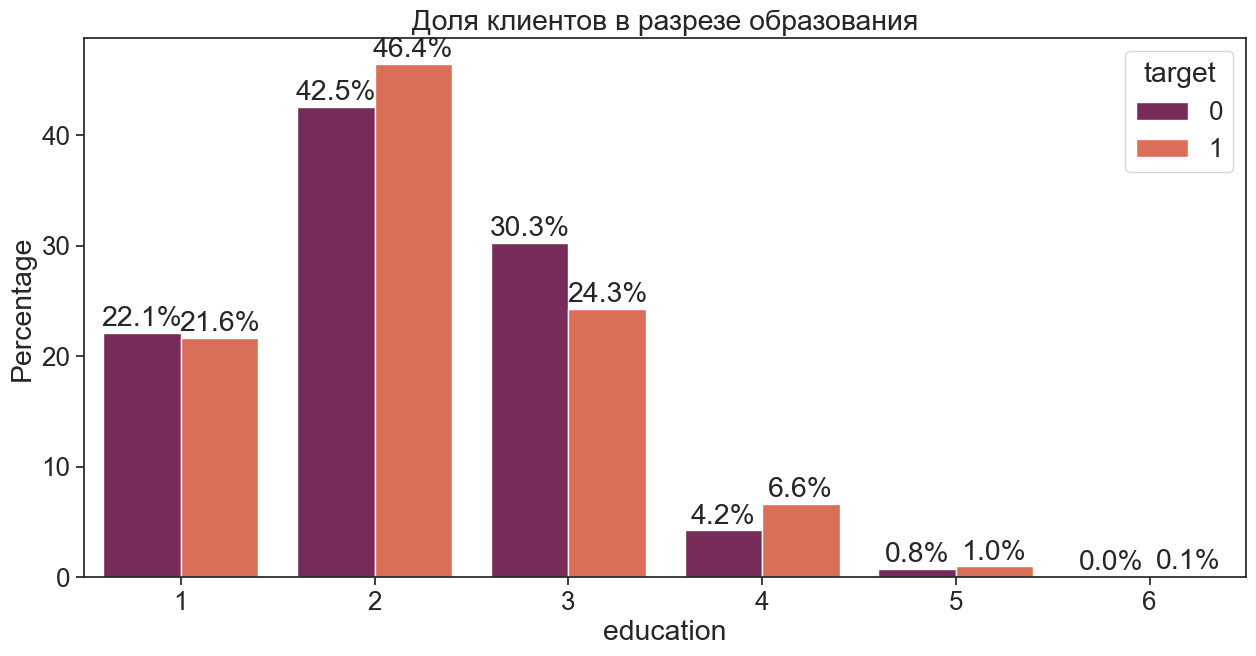

In [634]:
build_barplot_by_column(df, "education", "Доля клиентов в разрезе образования")

Наблюдаем что уровень образования не сильно влияет возврат кредита.

### Гипотеза 5.

Семейное положение влияет на возврат кредита.

In [635]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select("case_id", "maritalst_385M", "maritalst_893M")
lf = lf_base.join(lf_static_cb, how="left", on="case_id", suffix="_cb")
lf_p = scan_file(
    TRAIN_PREFIX + "person_1.parquet", depth=1, date_col="empl_employedfrom_271D"
)
lf_p = lf_p.select("case_id", "maritalst_703L")
lf = lf.join(lf_p, how="left", on="case_id", suffix="_per")
lf.slice(0, 10).collect()

parquet_files/train/train_person_1.parquet


shape: (10, 5)
┌─────────┬────────┬────────────────┬────────────────┬────────────────┐
│ case_id ┆ target ┆ maritalst_385M ┆ maritalst_893M ┆ maritalst_703L │
│ ---     ┆ ---    ┆ ---            ┆ ---            ┆ ---            │
│ i64     ┆ i64    ┆ str            ┆ str            ┆ str            │
╞═════════╪════════╪════════════════╪════════════════╪════════════════╡
│ 0       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 1       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 2       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 3       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 4       ┆ 1      ┆ null           ┆ null           ┆ null           │
│ 5       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 6       ┆ 0      ┆ null           ┆ null           ┆ SINGLE         │
│ 7       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 8       ┆ 0      ┆ null           ┆ null           ┆ null           │
│ 9       ┆ 0      ┆ null           ┆ null           ┆ null           │
└─────────┴────────┴────────────────┴────────────────┴────────────────┘

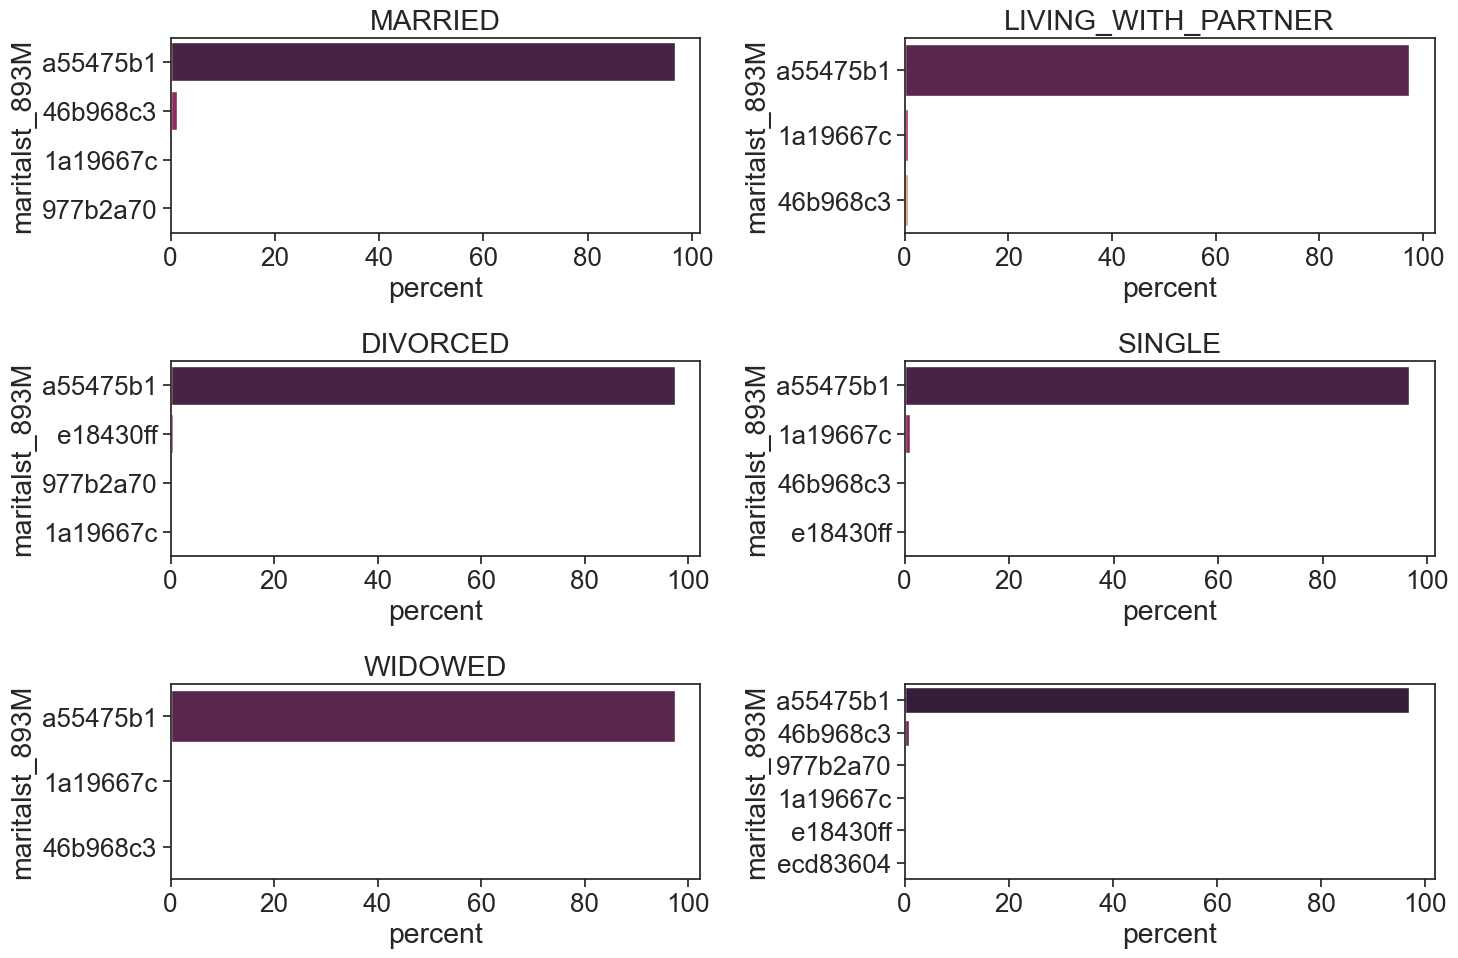

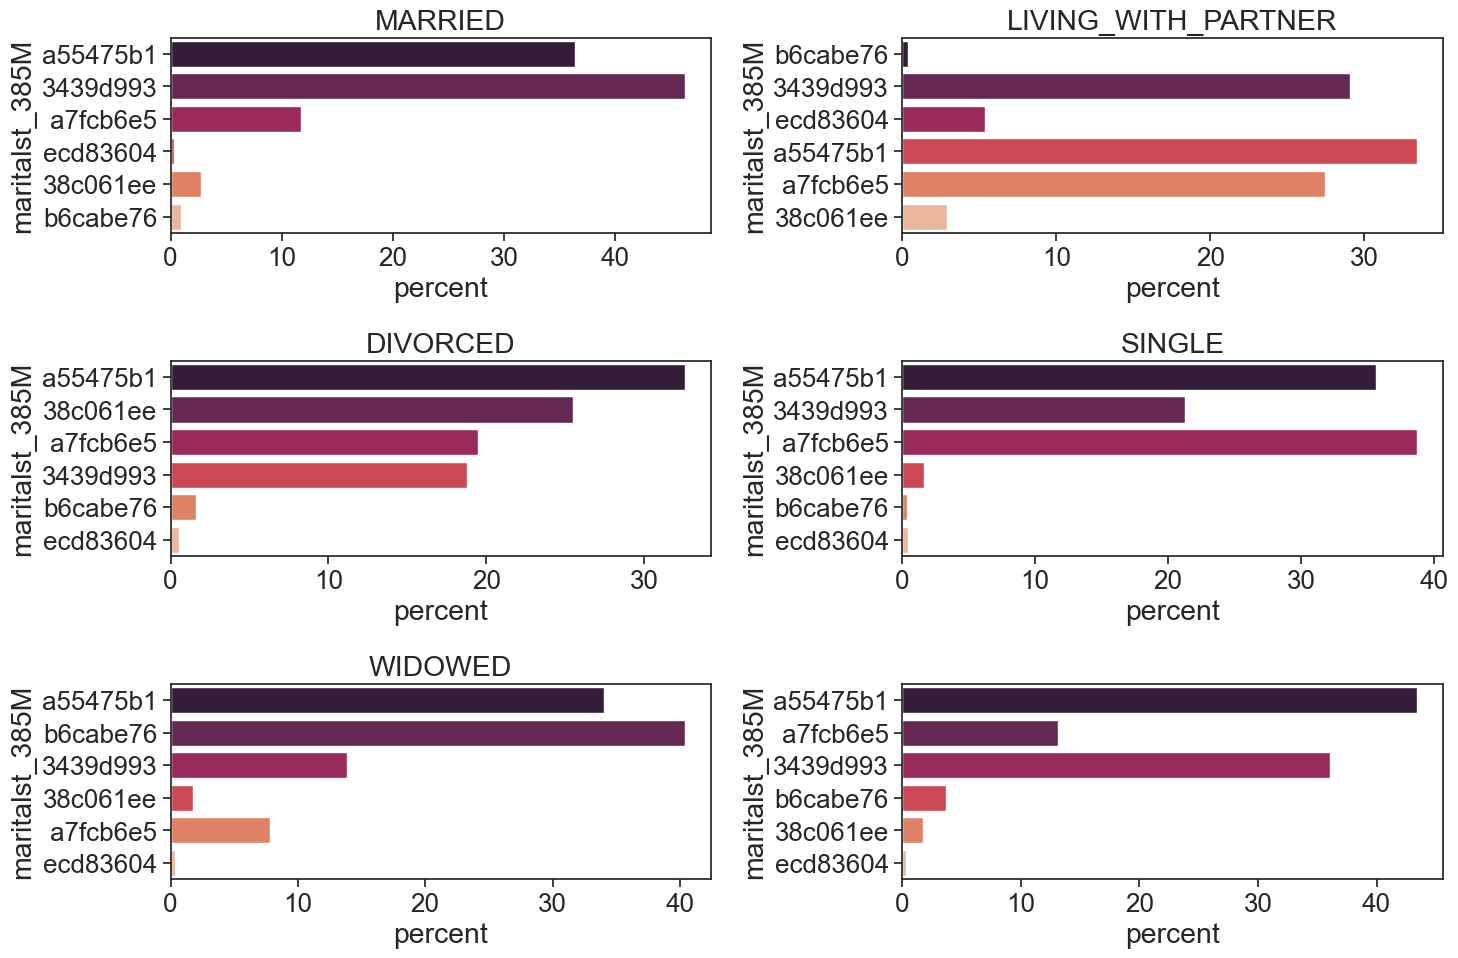

In [613]:
for col in ["maritalst_893M", "maritalst_385M"]:
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    vals = ["MARRIED", "LIVING_WITH_PARTNER", "DIVORCED", "SINGLE", "WIDOWED", None]
    for i, ax in enumerate(axes.flatten()):
        val = vals[i]
        df = (
            lf.filter(pl.col("maritalst_703L") == val).select(col).collect()
            if val is not None
            else lf.filter(pl.col("maritalst_703L").is_null()).select(col).collect()
        )
        snl.countplot(df, y=col, stat="percent", ax=ax, palette="rocket")
        ax.set_title(val)
    plt.tight_layout()

Трудно найти расшифровку этих значений. 

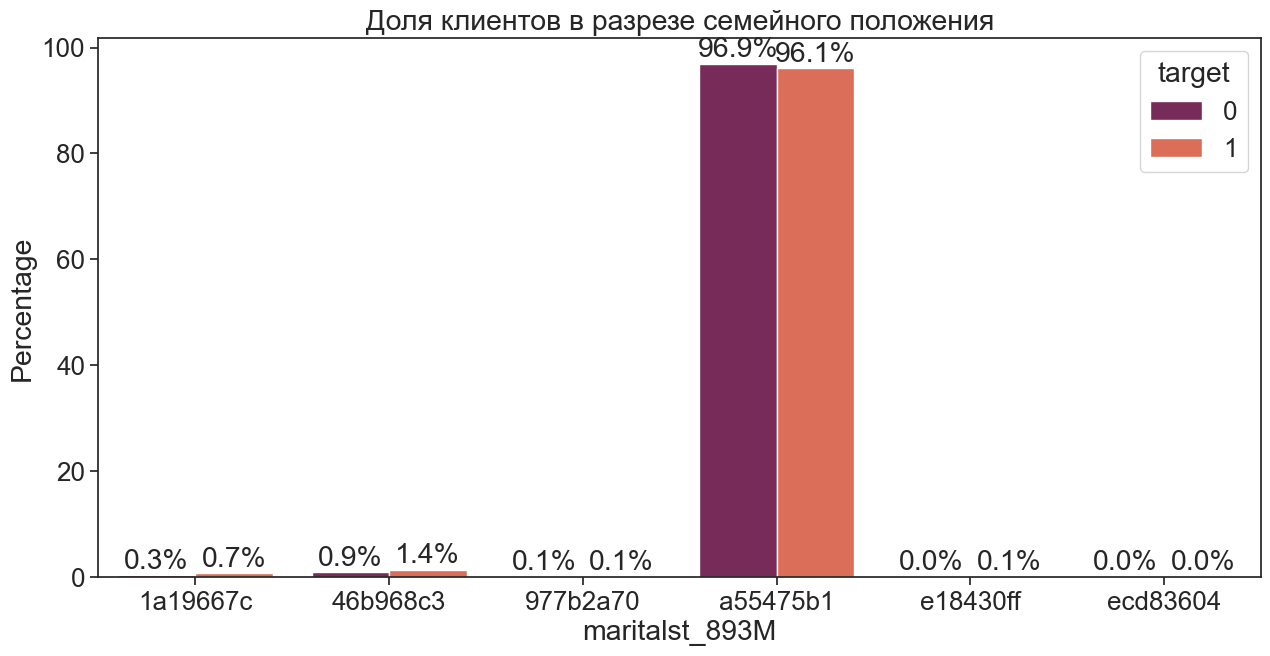

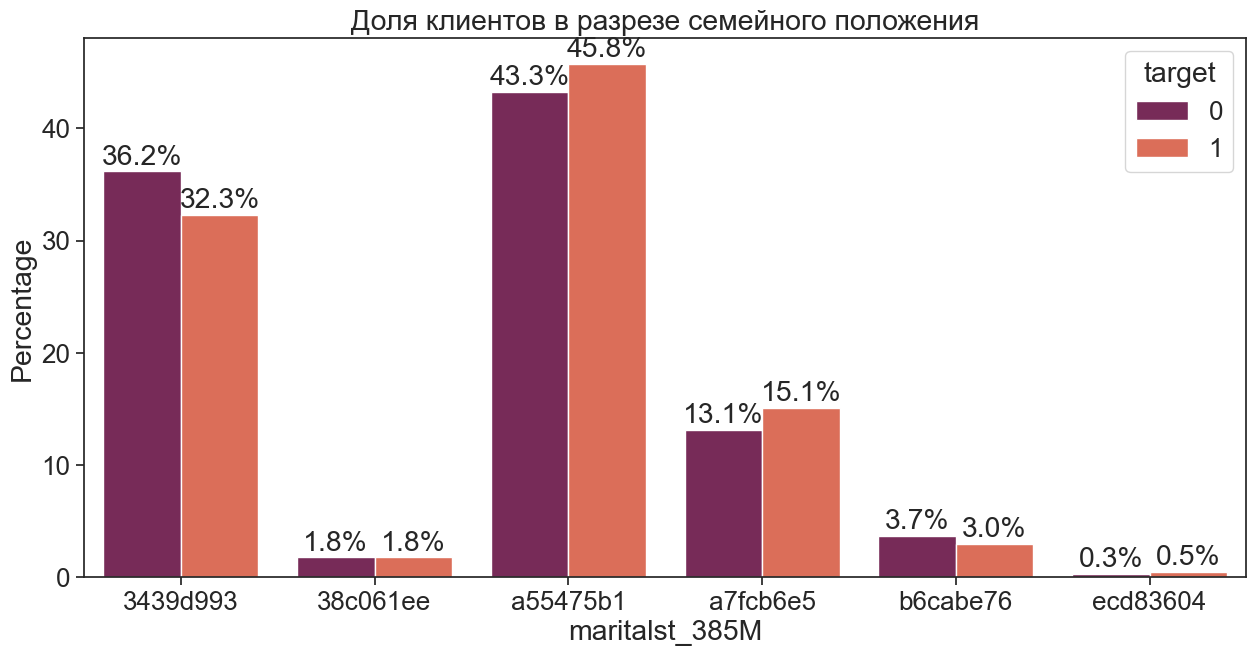

In [620]:
df = lf.collect().to_pandas()
build_barplot_by_column(
    df, "maritalst_893M", "Доля клиентов в разрезе семейного положения"
)
build_barplot_by_column(
    df, "maritalst_385M", "Доля клиентов в разрезе семейного положения"
)

Гипотеза частично верна, т.к. наблюдаются небольшие различия в несколько процентов. Также видим различное соотношение по категориям. Признак maritalst_893M неинформативен, его будем игнорировать.

### Гипотеза 6.

Для "хороших" и "плохих" заемщиков отношение типов запросов налогового органа отличаются. У "плохих" тип "deduction" встречается чаще.

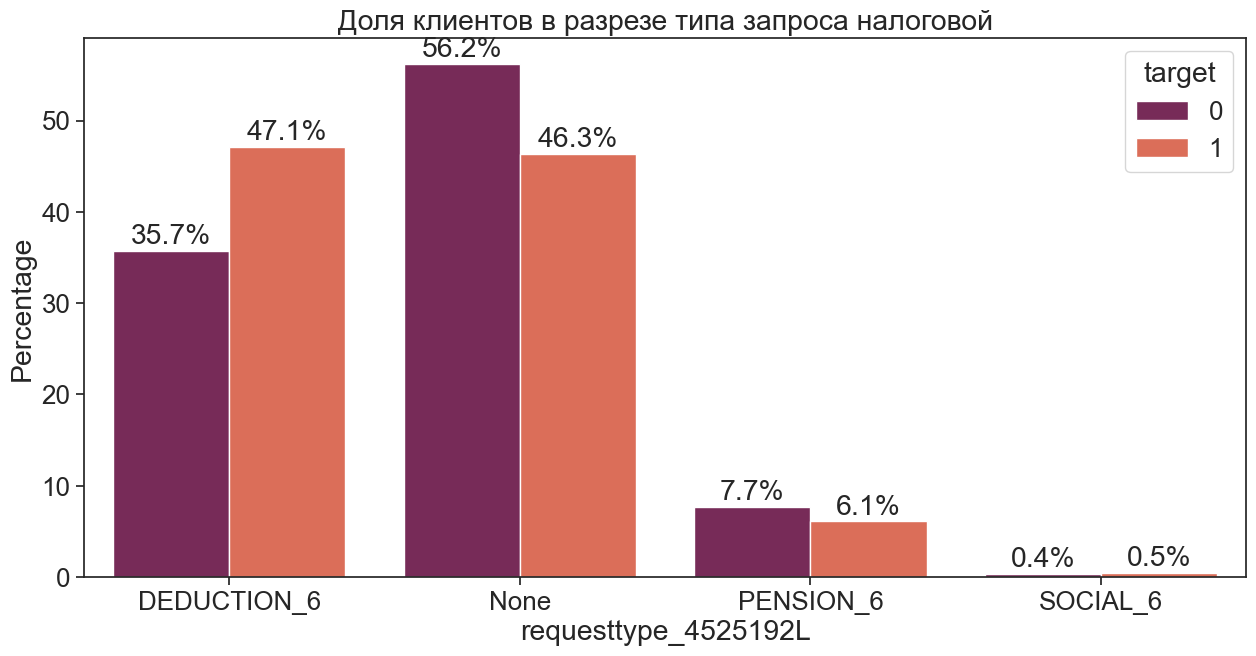

In [65]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_file(TRAIN_PREFIX + "static_cb_0.parquet")
lf_static_cb = lf_static_cb.select("case_id", "requesttype_4525192L")
lf = lf_base.join(lf_static_cb, how="left", on="case_id", suffix="_cb")
lf = lf.with_columns(pl.col("requesttype_4525192L").fill_null("None"))
df = lf.collect().to_pandas()
build_barplot_by_column(
    df, "requesttype_4525192L", "Доля клиентов в разрезе типа запроса налоговой"
)

Гипотеза верна, видим отличия в соотношении типов запросов для группы 0 и 1.

### Гипотеза 7.

Количество платежей, выплаченных досрочно за последние 24 месяца является информативным признаком. Есть различия между 0 и 1 группой, причем у 1 группы количество платежей меньше.

In [35]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_files(TRAIN_PREFIX + "static_0_*.parquet")
lf_static_cb = lf_static_cb.select("case_id", "amtinstpaidbefduel24m_4187115A")
lf = lf_base.join(lf_static_cb, how="left", on="case_id", suffix="_cb")

parquet_files/train/train_base.parquet
parquet_files/train\train_static_0_0.parquet
parquet_files/train\train_static_0_1.parquet


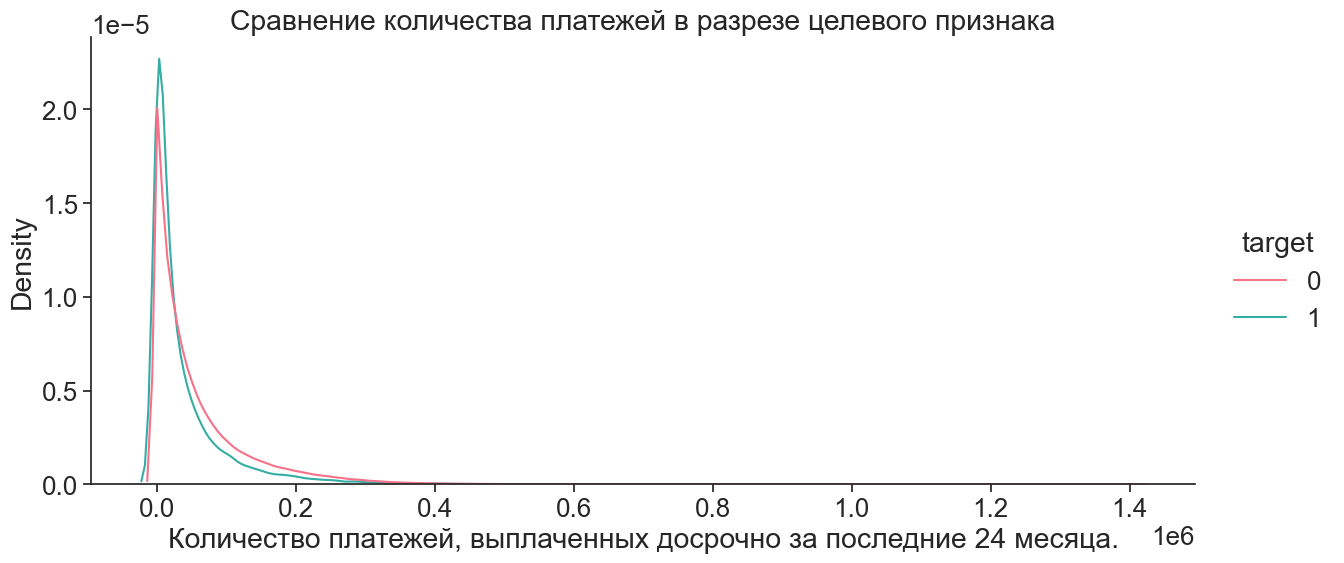

In [36]:
snl.displot(
    lf,
    x="amtinstpaidbefduel24m_4187115A",
    hue="target",
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette="husl",
)
plt.title("Сравнение количества платежей в разрезе целевого признака")
plt.xlabel("Количество платежей, выплаченных досрочно за последние 24 месяца.")
plt.show()

Распределение для признака amtinstpaidbefduel24m_4187115A target = 1 нормальное, pvalue = 1.0
Распределение для признака amtinstpaidbefduel24m_4187115A target = 0 нормальное, pvalue = 1.0
Средние различны, p-value=0.0
T test statistic = 44.30931155179345, pvalue = 0.0


  0%|          | 0/500 [00:00<?, ?it/s]

Средние различны, p-value=0.0
CI = (-8666.925, -8425.495525)


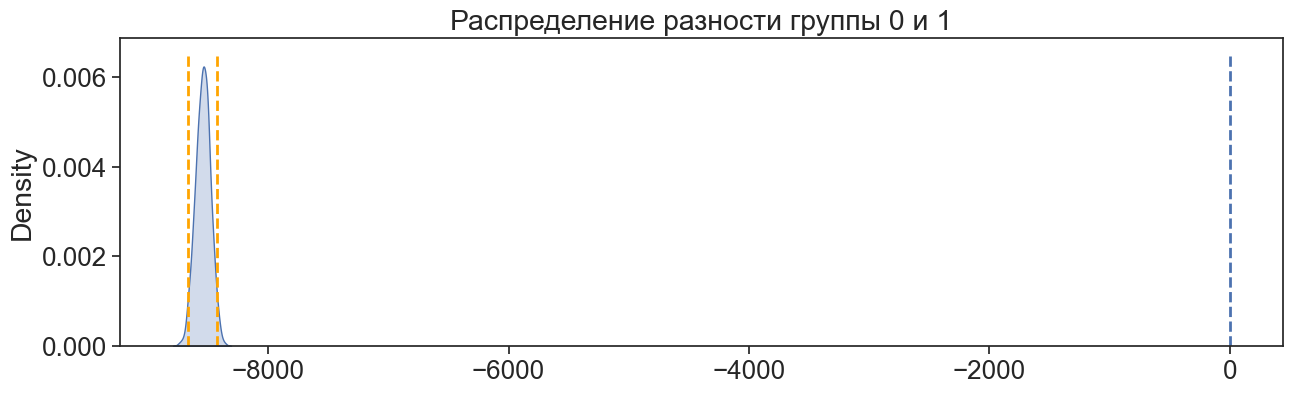

In [37]:
check_distributions_for_similarity(
    lf, "amtinstpaidbefduel24m_4187115A", count_generate=500
)

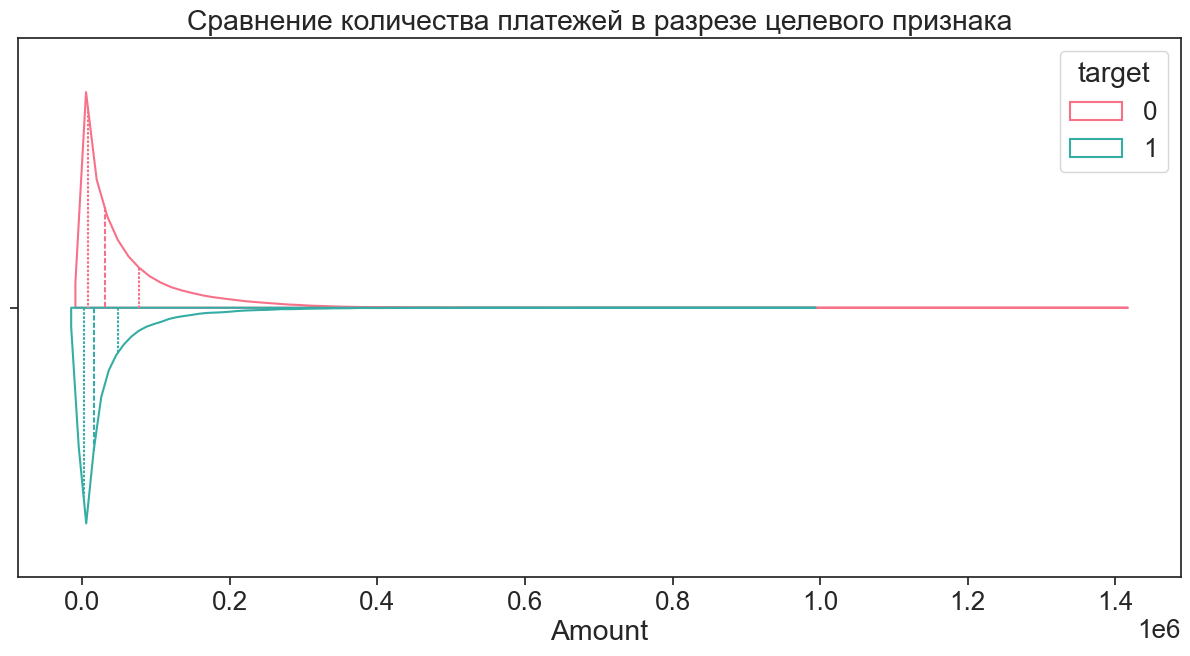

In [234]:
fig, ax = plt.subplots(figsize=(15, 7))
snl.violinplot(
    lf,
    x="amtinstpaidbefduel24m_4187115A",
    hue="target",
    orient="h",
    palette="husl",
    fill=0,
    inner="quart",
    split=True,
    ax=ax,
)
ax.set_xlabel("Amount")
ax.set_title("Сравнение количества платежей в разрезе целевого признака")
plt.show()

Гипотеза полностью подтверждена. Количество платежей, выплаченных досрочно за последние 24 месяца является информативным признаком. Есть различия между 0 и 1 группой, причем у 1 группы количество платежей меньше.

### Гипотеза 8.

Ежемесячная сумма платежа отличается между группами, у "хороших" заемщиков она в среднем меньше.

parquet_files/train/train_base.parquet
parquet_files/train\train_static_0_0.parquet
parquet_files/train\train_static_0_1.parquet


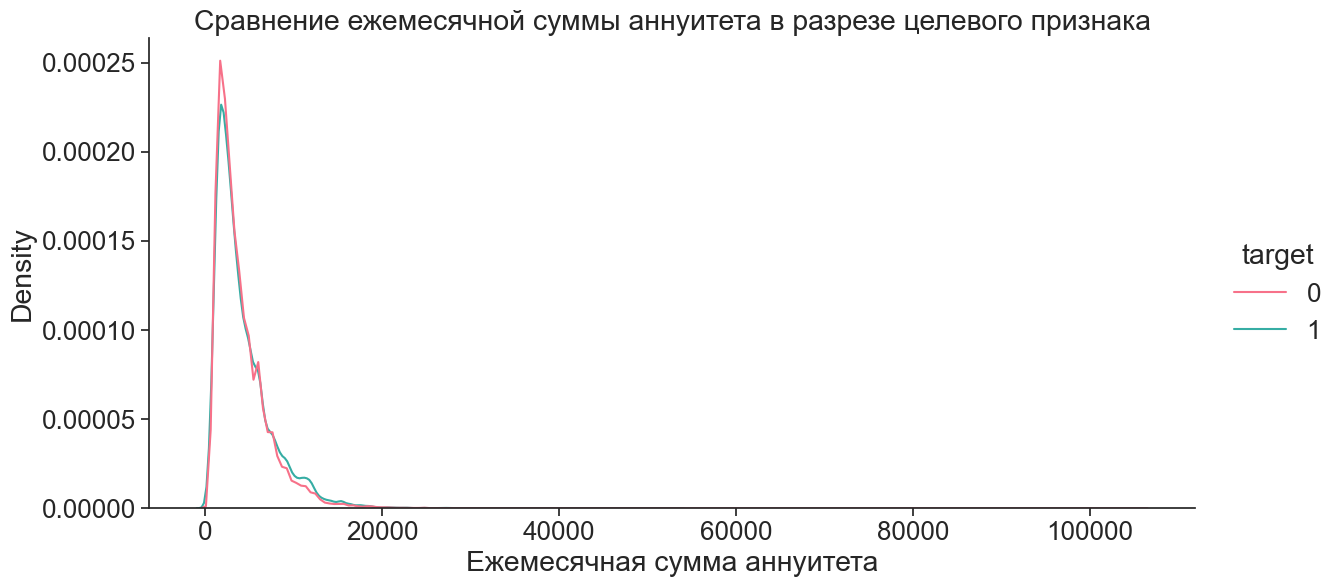

In [38]:
lf_base = ds._base_table()
lf_base = lf_base.select("case_id", "target")
lf_static_cb = scan_files(TRAIN_PREFIX + "static_0_*.parquet")
lf_static_cb = lf_static_cb.select("case_id", "annuity_780A")
lf = lf_base.join(lf_static_cb, how="left", on="case_id", suffix="_cb")
snl.displot(
    lf,
    x="annuity_780A",
    hue="target",
    kind="kde",
    common_norm=False,
    height=6,
    aspect=2.1,
    palette="husl",
)
plt.title("Сравнение ежемесячной суммы аннуитета в разрезе целевого признака")
plt.xlabel("Ежемесячная сумма аннуитета")
plt.show()

Распределение для признака annuity_780A target = 1 не нормальное, pvalue = 0.0
Распределение для признака annuity_780A target = 0 не нормальное, pvalue = 0.0
Средние различны, p-value=[1.45191988e-38]
 Mann–Whitney U Test for annuity_780A: statistic=[3.67175214e+10], p-value=[0.]


  0%|          | 0/500 [00:00<?, ?it/s]

Средние различны, p-value=0.0
CI = (114.39594949999976, 128.90085150000024)


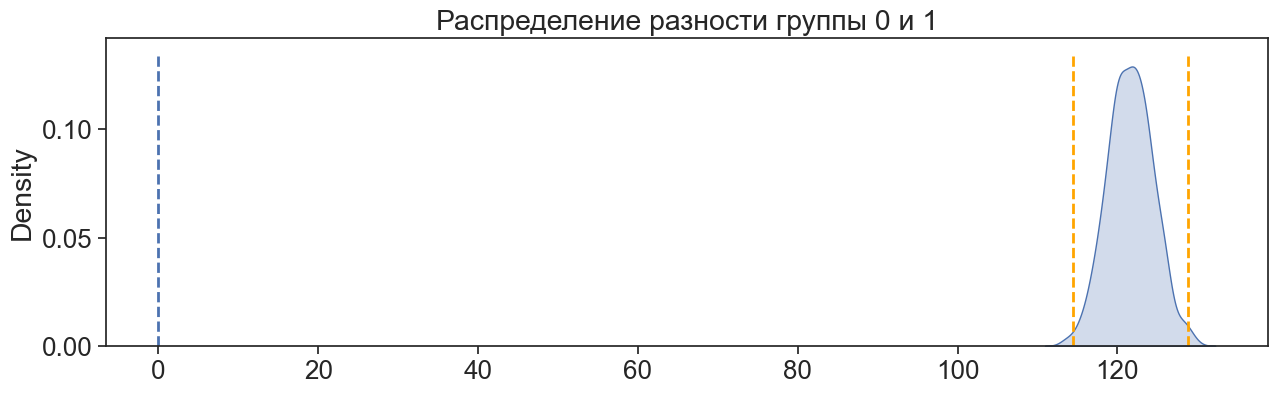

In [39]:
check_distributions_for_similarity(lf, "annuity_780A", count_generate=500, alpha=0.01)

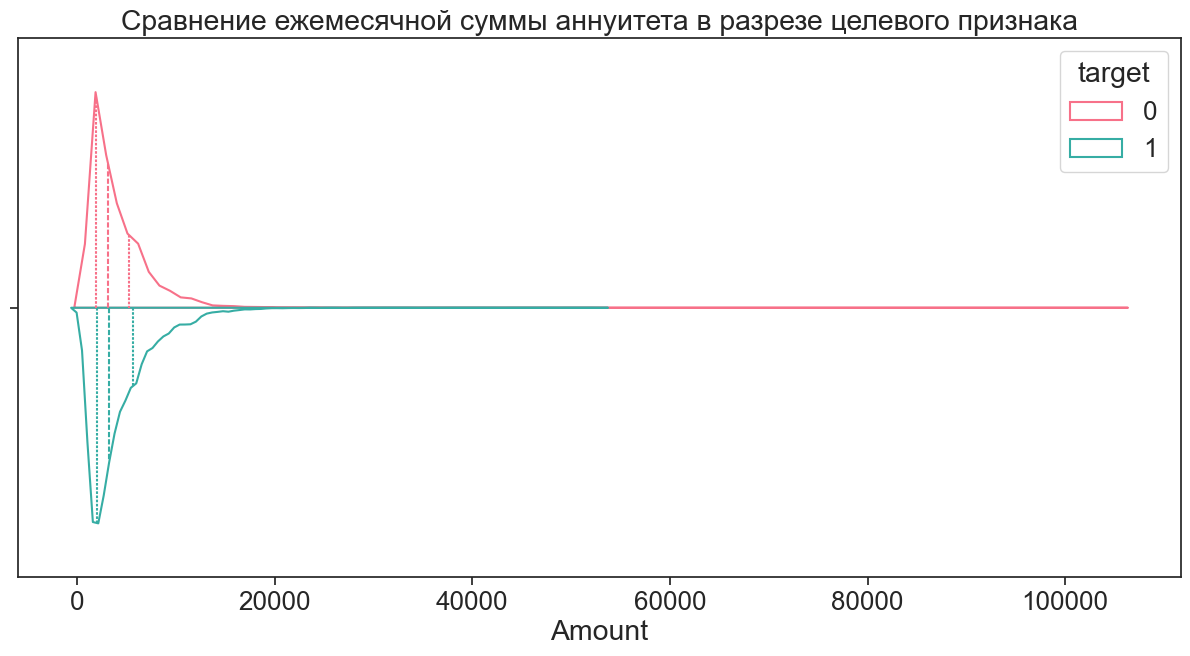

In [231]:
fig, ax = plt.subplots(figsize=(15, 7))
snl.violinplot(
    lf,
    x="annuity_780A",
    hue="target",
    orient="h",
    palette="husl",
    fill=0,
    inner="quart",
    split=True,
    ax=ax,
)
ax.set_xlabel("Amount")
ax.set_title("Сравнение ежемесячной суммы аннуитета в разрезе целевого признака")
plt.show()

In [232]:
med_1 = (
    lf.filter(pl.col("target") == 1).select("annuity_780A").median().collect().item()
)
med_0 = (
    lf.filter(pl.col("target") == 0).select("annuity_780A").median().collect().item()
)
print(f"Median for 0 = {med_0}, for 1 = {med_1}")

Median for 0 = 3149.0, for 1 = 3285.4001


Гипотеза подтверждена. Различия есть. Ежемесячная сумма аннуитета отличается между группами, у "хороших" заемщиков она в среднем меньше.

### Гипотеза 9.

Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше и у "плохих" заемщиков доход внутри группы ниже.

In [ ]:
ds = Dataset()
df = ds.get_dataframe()
df_p = df.to_pandas()

In [157]:
X = df_p.drop(["WEEK_NUM", "case_id"], axis=1)

In [127]:
scaler = StandardScaler()
X_num = X._get_numeric_data()
X_num = scaler.fit_transform(X_num)

In [128]:
X_num = pd.DataFrame(X_num, columns=X._get_numeric_data().columns)

In [129]:
cat_features = X.select_dtypes(object).columns.tolist()
X_std = pd.concat([X_num, X[cat_features]], axis=1)

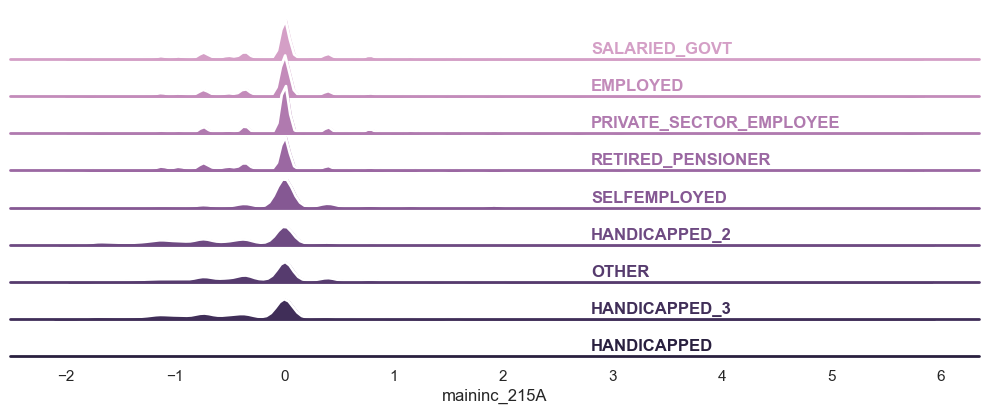

In [113]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
draw_overlapping_densities(X_std, "maininc_215A", "incometype_1044T")

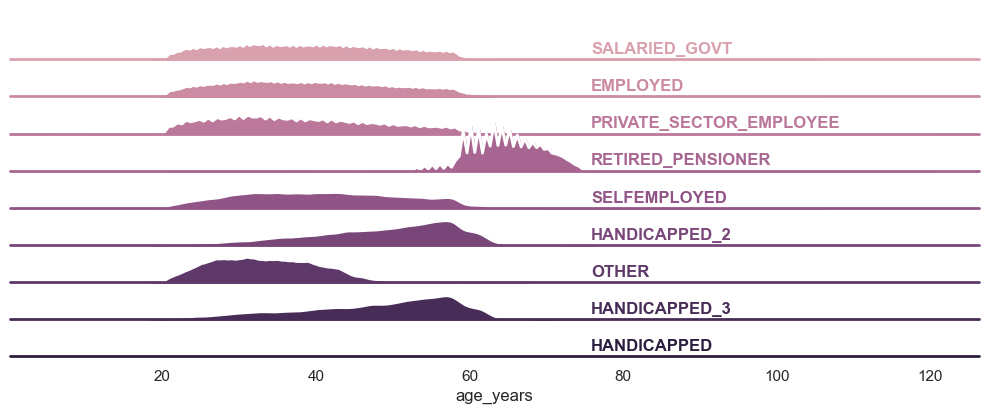

In [114]:
draw_overlapping_densities(X, "age_years", "incometype_1044T")

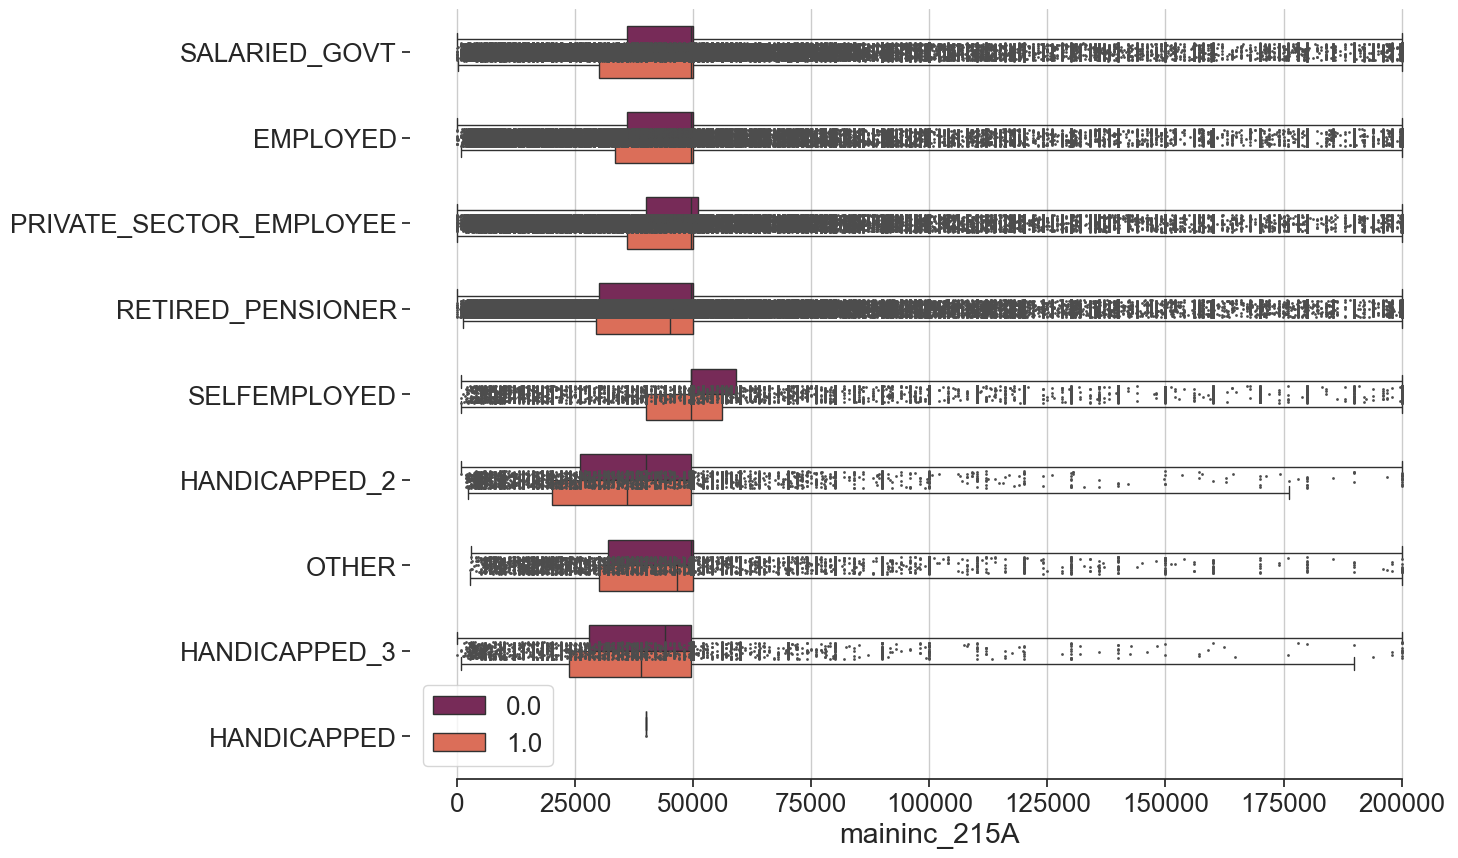

In [166]:
sns.set_theme(style="ticks", font_scale=1.7)
f, ax = plt.subplots(figsize=(15, 9))
sns.boxplot(
    X,
    x="maininc_215A",
    y="incometype_1044T",
    hue="target",
    whis=[0, 100],
    width=0.6,
    palette="rocket",
)
sns.stripplot(X, x="maininc_215A", y="incometype_1044T", color=".3", size=2)
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt.tight_layout()

В целом гипотеза оказалась верна. Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше, чем у пенсионеров, инвалидов и других. Но интерквартильный размах у всех категорий находится в районе 25 - 50 тыс.
У "плохих" заемщиков доход внутри группы чуть ниже, по медианному значению

### Гипотеза 10.

Размер кредита (price_1097A) зависит от дохода клиента (maininc_215A), чем выше доход, тем выше размер кредита. Количество дней просрочки больше у клиентов с меньшим размером дохода.

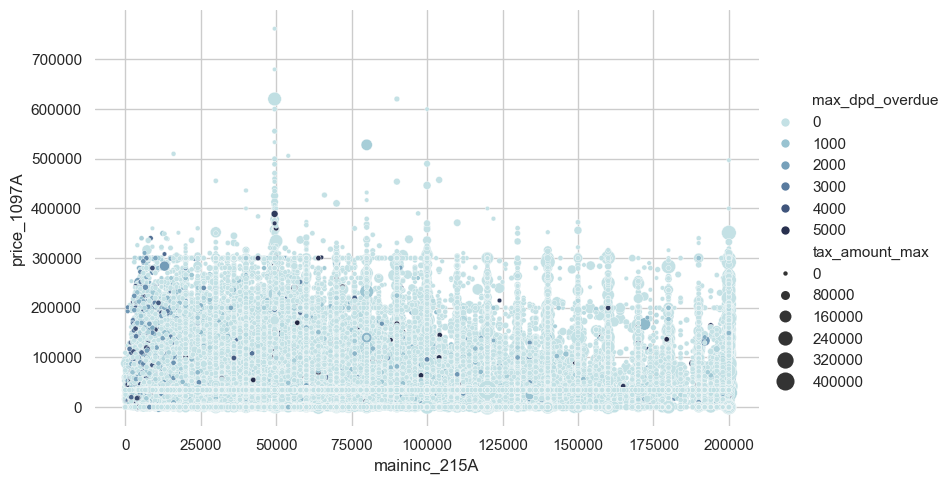

In [202]:
sns.set_theme(style="whitegrid", font_scale=1)
cmap = sns.cubehelix_palette(rot=-0.2, as_cmap=True)
g = sns.relplot(
    X,
    x="maininc_215A",
    y="price_1097A",
    hue="max_dpd_overdue",
    size="tax_amount_max",
    palette=cmap,
    sizes=(10, 200),
    aspect=1.6,
)

g.ax.xaxis.grid(True, "minor", linewidth=0.25)
g.ax.yaxis.grid(True, "minor", linewidth=0.25)
g.despine(left=True, bottom=True)

Гипотеза наполовину верна. Видим, что размер кредита (price_1097A) имеет некоторую зависимость от дохода клиента (maininc_215A), чем выше доход, тем ниже размер кредита и заинтересованность в нем вообще, а не выше. Также видим, что и количество дней просрочки больше именно у группы с доходами ниже 25000.

### Выводы по гипотезам

- Количество запросов в кредитное бюро за последние 360, 180, 120, 90, 30 дней отличаются для двух классов. Чем выше количество запросов тем выше вероятность дефолта по кредиту.
- Количество результатов, полученных от кредитного бюро в 1-4 квартале указывают на вероятность дефолта по кредиту. И данные признаки информативны.
- Трудно сказать что категоризация клиентов в кредитном бюро информативна, т.к. обе группы в основном имеют одну категорию. Вариация очень малая, а другие категории встречаются очень редко. Приходим к выводу что этот признак неинформативен и его можно исключить.
- Уровень образования не сильно влияет на вероятность дефолта.
- Семейное положение частично влияет на возврат кредита, т.к. наблюдаются небольшие различия в данных.
- Для "хороших" и "плохих" заемщиков отношение типов запросов налогового органа отличаются. У "плохих" тип "deduction" встречается чаще.
- Количество платежей, выплаченных досрочно за последние 24 месяца является информативным признаком. Есть различия между 0 и 1 группой, причем у 1 группы количество платежей меньше.
- Ежемесячный размер платежа отличается между группами, у "хороших" заемщиков она в среднем меньше.
- Сумма основного дохода клиента (maininc_215A) сильно зависит от вида дохода человека (Incometype_1044T). У работающих клиентов доход выше, чем у пенсионеров, инвалидов и других. Но интерквартильный размах у всех категорий находится в районе 25 - 50 тыс. У "плохих" заемщиков доход внутри группы чуть ниже, по медианному значению.
- Размер кредита (price_1097A) имеет некоторую зависимость от дохода клиента (maininc_215A), чем выше доход, тем ниже размер кредита и заинтересованность в нем вообще, а не выше. Также видим, что и количество дней просрочки больше именно у группы с доходами ниже 25000.

# Выводы

Проведен разведочный анализ данных.
- С помощью обзора таблиц и анализа корреляции выявлены взаимосвязи между признаками, что помогло объдинить их по смыслу и значениям.
- Удалили признаки с высокой долей пропусков.
- Нашли наиболее подходящий способ заполнения пропусков - константа 'None' для категориальных, числовые оставить как есть.
- Нашли неинформативные признаки с помощью VarianceThreshold, SelectKBest и CatBoost RFE.
- В итоге количество признаков сокращено до 190. Изначально было 488. 
- Некоторые исследования взаимосвязи признаков с целевой переменной оформили в виде анализа гипотез.
- Для дальнейшего обучения моделей создан класс Dataset, который формирует датасет из всех таблиц, объединяет признаки в соответствии с проведенным анализом.